In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

def analyze_energy_data(primary_path, control_path, external_plant_info_path, bacode, fuel_types, reg_var):
    # Load the primary dataset
    primary = pd.read_csv(
        primary_path,
        parse_dates=["timestamp"],
    )

    # Load the control dataset
    control = pd.read_csv(
        control_path,
        parse_dates=["Local time"],
    ).rename(columns={"Local time": "timestamp"})

    # Process and merge primary and control datasets
    control['timestamp'] = pd.to_datetime(control['timestamp'])
    primary['timestamp'] = pd.to_datetime(primary['timestamp'].astype(str).str[:-6])
    primary.set_index('timestamp', inplace=True)
    merged_data = primary.merge(control, on="timestamp", how="left")

    # Add date-related columns and drop NaNs
    merged_data["month"] = merged_data.timestamp.dt.month
    merged_data["year"] = merged_data.timestamp.dt.year
    merged_data["day"] = merged_data.timestamp.dt.day
    merged_data.dropna(inplace=True)

    # Filter out rows with 0 or negative values in specified columns
    positive_value_columns = ["solar", "wind", "SUN_ext", "WND_ext", "D_ext", "Wramp"]
    for column in positive_value_columns:
        merged_data = merged_data[merged_data[column] > 0]

    # Calculate residual demand
    merged_data["residual_demand"] = merged_data.demand + merged_data.imports - merged_data.hydro

    # Log-transform specified columns
    def log_df(df):
        df = df.replace(0, np.nan).dropna()
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
        log_transform_columns = ["generation", "demand", "solar", "wind", "SUN_ext", "WND_ext", "D_ext", "Wramp", "co2", "intensity", "residual_demand"]
        for column in log_transform_columns:
            df[column] = np.log(df[column])
        return df

    # OLS regression function
    def ols_regression(df, variable, log=False):
        if log:
            df = log_df(df)
        model = smf.ols(
            formula=f"{variable} ~ residual_demand + solar + wind + SUN_ext + WND_ext + D_ext + Wramp + C(month) + C(year) + solar*C(year) + C(type)",
            data=df,
        ).fit()
        return model

    # Perform OLS regression for each plant
    plant_ols_results = []
    cols = ["id", "rsquared", "residual_demand_coeff", "residual_demand_std", "solar_coeff", "solar_std", "solar_sig", "wind_coeff", "wind_std", "wind_sig", "wramp_coeff", "wramp_std", "wramp_sig"]
    for plant_id in merged_data.id.unique():
        temp_df = merged_data[merged_data.id == plant_id]
        try:
            model_results = ols_regression(temp_df, reg_var, log=True)
            results = {
                "id": plant_id,
                "rsquared": round(model_results.rsquared, 3),
                "residual_demand_coeff": round(model_results.params['residual_demand'], 3),
                "residual_demand_std": round(model_results.bse['residual_demand'], 3),
                "solar_coeff": round(model_results.params['solar'], 3),
                "solar_std": round(model_results.bse['solar'], 3),
                "solar_sig": round(model_results.pvalues['solar'], 3),
                "wind_coeff": round(model_results.params['wind'], 3),
                "wind_std": round(model_results.bse['wind'], 3),
                "wind_sig": round(model_results.pvalues['wind'], 3),
                "wramp_coeff": round(model_results.params['Wramp'], 3),
                "wramp_std": round(model_results.bse['Wramp'], 3),
                "wramp_sig": round(model_results.pvalues['Wramp'], 3),
            }
            plant_ols_results.append(results)
        except Exception as e:
            continue

    plant_ols_df = pd.DataFrame(plant_ols_results, columns=cols)

    # Load external plant information
    df_plants_info = pd.read_excel(
        external_plant_info_path,
        skiprows=1,
        usecols=["ORISPL", "NAMEPCAP", "BACODE", "LAT", "LON", "PLPRMFL", "PLFUELCT", "CAPFAC", "CHPFLAG", "PLNGENAN", "PLNOXAN", "PLSO2AN", "PLCO2AN", "PLHTRT", "PSTATABB", "ISORTO"],
        sheet_name="PLNT20",
    )

    # Filter based on BACODE and fuel types
    df_plants_filtered = df_plants_info[(df_plants_info.BACODE == bacode) & (df_plants_info.PLFUELCT.isin(fuel_types))].rename(columns={"ORISPL": "id"})

    # Merge with OLS results
    final_df = plant_ols_df.merge(df_plants_filtered, on="id", how="inner")

    # Calculate emission intensities
    final_df["NOXEI"] = final_df["PLNOXAN"] / final_df["PLNGENAN"]
    final_df["SO2EI"] = final_df["PLSO2AN"] / final_df["PLNGENAN"]
    final_df["CO2EI"] = final_df["PLCO2AN"] / final_df["PLNGENAN"]

    return final_df

In [2]:
df_ciso_analysis_G = analyze_energy_data(
    'CISO_merged_H.csv',
    'CISO_control.csv',
    'eGRID2020_Data_v2.xlsx',
    'CISO',
    ['GAS', 'OIL', 'COAL'],
    "generation"
)

In [5]:
df_ciso_analysis_G

,id,rsquared,residual_demand_coeff,residual_demand_std,solar_coeff,solar_std,solar_sig,wind_coeff,wind_std,wind_sig,...,NAMEPCAP,CHPFLAG,PLNGENAN,PLNOXAN,PLSO2AN,PLCO2AN,PLHTRT,NOXEI,SO2EI,CO2EI
0,335,0.649,1.350,0.061,0.024,0.014,0.090,-0.118,0.011,0.000,...,1021.0,NaN,107419.00,29.994,2.800,562100.000,88052.340601,0.000279,0.000026,5.232780
1,358,0.298,1.423,0.094,-0.065,0.022,0.003,-0.064,0.018,0.000,...,1167.4,NaN,2866899.99,68.216,6.400,1270879.562,7459.238725,0.000024,0.000002,0.443294
2,50865,0.269,-0.050,0.007,-0.007,0.002,0.001,0.018,0.001,0.000,...,38.9,Yes,254600.00,8.316,0.478,94909.293,6272.631523,0.000033,0.000002,0.372778
3,55182,0.231,0.294,0.071,-0.073,0.013,0.000,-0.065,0.012,0.000,...,685.2,NaN,2968009.00,57.901,6.200,1237093.188,7013.624622,0.000020,0.000002,0.416809
4,55217,0.289,0.644,0.029,-0.007,0.007,0.316,-0.037,0.006,0.000,...,678.3,Yes,2976024.00,73.012,5.910,1170915.613,6620.543527,0.000025,0.000002,0.393450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,57267,0.270,1.448,0.305,0.048,0.073,0.511,0.021,0.051,0.673,...,828.0,NaN,265306.00,11.652,0.900,180329.697,11437.349820,0.000044,0.000003,0.679705
78,10405,0.130,0.942,0.308,-0.340,0.086,0.000,0.164,0.067,0.014,...,36.2,Yes,3282.00,0.226,0.000,1923.471,9861.995391,0.000069,0.000000,0.586067
79,10169,0.265,0.857,0.272,-0.049,0.041,0.239,0.144,0.039,0.000,...,55.8,Yes,20377.00,12.158,0.100,11209.500,9256.203379,0.000597,0.000005,0.550106
80,60698,0.232,1.880,0.627,0.039,0.071,0.587,0.023,0.074,0.751,...,161.0,NaN,20837.00,1.880,0.200,28204.900,22775.227810,0.000090,0.000010,1.353597


In [4]:
units_ciso = pd.read_csv('largest_units_ciso.csv')
units_ciso['Unit Type'] = units_ciso['Unit Type'].replace(to_replace=r'^Combustion turbine.*', 
                                                          value='Combustion turbine', regex=True)

units_ciso.rename(columns={'Facility ID': 'id'}, inplace=True)

In [5]:
units_erco = pd.read_csv('largest_units_ercot.csv')
units_erco['Unit Type'] = units_erco['Unit Type'].replace(to_replace=r'^Combustion turbine.*', 
                                                          value='Combustion turbine', regex=True)

units_erco.rename(columns={'Facility ID': 'id'}, inplace=True)

In [6]:
df_ciso_analysis_G = analyze_energy_data(
    'CISO_merged_H.csv',
    'CISO_control.csv',
    'eGRID2020_Data_v2.xlsx',
    'CISO',
    ['GAS', 'OIL', 'COAL'],
    "generation"
)

df_ciso_analysis_C = analyze_energy_data(
    'CISO_merged_H.csv',
    'CISO_control.csv',
    'eGRID2020_Data_v2.xlsx',
    'CISO',
    ['GAS', 'OIL', 'COAL'],
    "co2"
)

df_ciso_analysis_EI = analyze_energy_data(
    'CISO_merged_H.csv',
    'CISO_control.csv',
    'eGRID2020_Data_v2.xlsx',
    'CISO',
    ['GAS', 'OIL', 'COAL'],
    "intensity"
)

df_ciso_analysis_G = pd.merge(df_ciso_analysis_G, units_ciso, how = 'left', on='id')
df_ciso_analysis_C = pd.merge(df_ciso_analysis_C, units_ciso, how = 'left', on='id')
df_ciso_analysis_EI = pd.merge(df_ciso_analysis_EI, units_ciso, how = 'left', on='id')

In [7]:
df_erco_analysis_G = analyze_energy_data(
    'ERCO_merged_H.csv',
    'ERCO_control.csv',
    'eGRID2020_Data_v2.xlsx',
    'ERCO',
    ['GAS', 'OIL', 'COAL'],
    "generation"
)

df_erco_analysis_C = analyze_energy_data(
    'ERCO_merged_H.csv',
    'ERCO_control.csv',
    'eGRID2020_Data_v2.xlsx',
    'ERCO',
    ['GAS', 'OIL', 'COAL'],
    "co2"
)

df_erco_analysis_EI = analyze_energy_data(
    'ERCO_merged_H.csv',
    'ERCO_control.csv',
    'eGRID2020_Data_v2.xlsx',
    'ERCO',
    ['GAS', 'OIL', 'COAL'],
    "intensity"
)

df_erco_analysis_G = pd.merge(df_erco_analysis_G, units_erco, how = 'left', on='id')
df_erco_analysis_C = pd.merge(df_erco_analysis_C, units_erco, how = 'left', on='id')
df_erco_analysis_EI = pd.merge(df_erco_analysis_EI, units_erco, how = 'left', on='id')

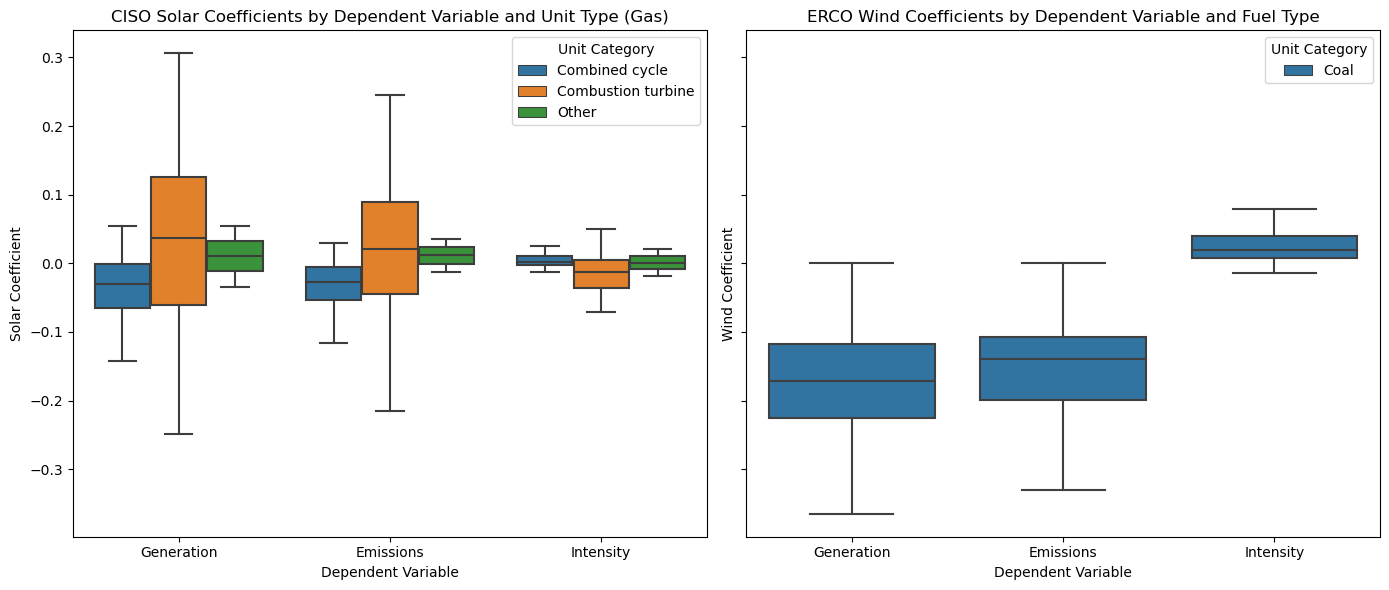

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Create a combined dataframe for CISO
df_ciso_analysis_G['dependent_var'] = 'Generation'
df_ciso_analysis_C['dependent_var'] = 'Emissions'
df_ciso_analysis_EI['dependent_var'] = 'Intensity'

# Concatenate the CISO dataframes
df_ciso_combined = pd.concat([df_ciso_analysis_G, df_ciso_analysis_C, df_ciso_analysis_EI])

# Modify 'Unit Type' column for Gas categories (Combined cycle, Combustion turbine, Other)
df_ciso_combined['Unit Category'] = df_ciso_combined.apply(
    lambda x: x['Unit Type'] if x['Unit Type'] in ['Combined cycle', 'Combustion turbine']
    else 'Other', axis=1)

# Step 2: Create a combined dataframe for ERCO
df_erco_analysis_G['dependent_var'] = 'Generation'
df_erco_analysis_C['dependent_var'] = 'Emissions'
df_erco_analysis_EI['dependent_var'] = 'Intensity'

# Concatenate the ERCO dataframes
df_ercot_combined = pd.concat([df_erco_analysis_G, df_erco_analysis_C, df_erco_analysis_EI])

# Modify 'PLFUELCT' column for Gas vs Coal and create unit categories for Gas
df_ercot_combined['Unit Category'] = df_ercot_combined.apply(
    lambda x: x['Unit Type'] if (x['PLFUELCT'] == 'Gas' and x['Unit Type'] in ['Combined cycle', 'Combustion turbine'])
    else 'Other' if x['PLFUELCT'] == 'Gas' else 'Coal', axis=1)

# Step 3: Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# First subplot (CISO - Solar Coefficients with 3 subticks per category)
sns.boxplot(x='dependent_var', y='solar_coeff', hue='Unit Category', data=df_ciso_combined, ax=ax1, showfliers=False)
ax1.set_title('CISO Solar Coefficients by Dependent Variable and Unit Type (Gas)')
ax1.set_xlabel('Dependent Variable')
ax1.set_ylabel('Solar Coefficient')
ax1.legend_.set_title('Unit Category')

# Second subplot (ERCO - Wind Coefficients with Gas and Coal)
sns.boxplot(x='dependent_var', y='wind_coeff', hue='Unit Category', data=df_ercot_combined, ax=ax2, showfliers=False)
ax2.set_title('ERCO Wind Coefficients by Dependent Variable and Fuel Type')
ax2.set_xlabel('Dependent Variable')
ax2.set_ylabel('Wind Coefficient')
ax2.legend_.set_title('Unit Category')

plt.tight_layout()
plt.show()


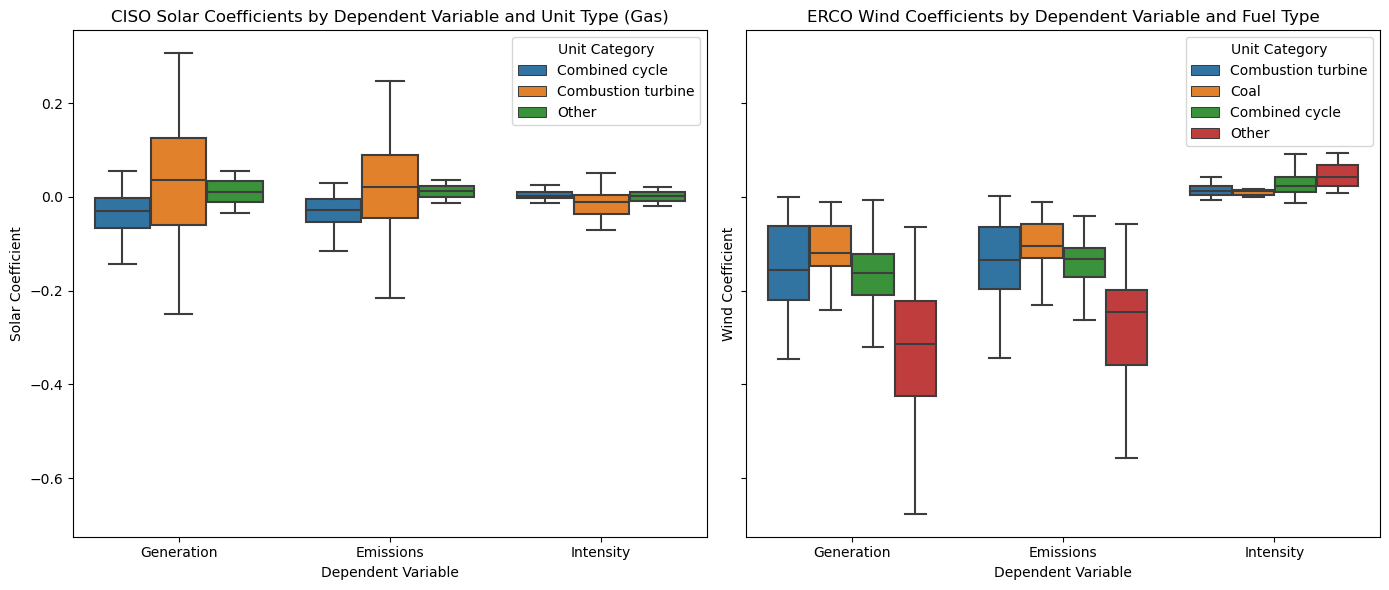

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Create a combined dataframe for CISO
df_ciso_analysis_G['dependent_var'] = 'Generation'
df_ciso_analysis_C['dependent_var'] = 'Emissions'
df_ciso_analysis_EI['dependent_var'] = 'Intensity'

# Concatenate the CISO dataframes
df_ciso_combined = pd.concat([df_ciso_analysis_G, df_ciso_analysis_C, df_ciso_analysis_EI])

# Modify 'Unit Type' column for Gas categories (Combined cycle, Combustion turbine, Other)
df_ciso_combined['Unit Category'] = df_ciso_combined.apply(
    lambda x: x['Unit Type'] if x['Unit Type'] in ['Combined cycle', 'Combustion turbine']
    else 'Other', axis=1)

# Step 2: Create a combined dataframe for ERCO
df_erco_analysis_G['dependent_var'] = 'Generation'
df_erco_analysis_C['dependent_var'] = 'Emissions'
df_erco_analysis_EI['dependent_var'] = 'Intensity'

# Concatenate the ERCO dataframes
df_ercot_combined = pd.concat([df_erco_analysis_G, df_erco_analysis_C, df_erco_analysis_EI])

# Modify 'Unit Category' for ERCO to separate Gas into three categories and leave Coal as a single category
df_ercot_combined['Unit Category'] = df_ercot_combined.apply(
    lambda x: 'Combined cycle' if x['PLFUELCT'] == 'GAS' and x['Unit Type'] == 'Combined cycle'
    else 'Combustion turbine' if x['PLFUELCT'] == 'GAS' and x['Unit Type'] == 'Combustion turbine'
    else 'Other' if x['PLFUELCT'] == 'GAS'
    else 'Coal', axis=1)

# Step 3: Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# First subplot (CISO - Solar Coefficients with 3 subticks per category)
sns.boxplot(x='dependent_var', y='solar_coeff', hue='Unit Category', data=df_ciso_combined, ax=ax1, showfliers=False)
ax1.set_title('CISO Solar Coefficients by Dependent Variable and Unit Type (Gas)')
ax1.set_xlabel('Dependent Variable')
ax1.set_ylabel('Solar Coefficient')
ax1.legend_.set_title('Unit Category')

# Second subplot (ERCO - Wind Coefficients with Gas and Coal)
sns.boxplot(x='dependent_var', y='wind_coeff', hue='Unit Category', data=df_ercot_combined, ax=ax2, showfliers=False)
ax2.set_title('ERCO Wind Coefficients by Dependent Variable and Fuel Type')
ax2.set_xlabel('Dependent Variable')
ax2.set_ylabel('Wind Coefficient')
ax2.legend_.set_title('Unit Category')

plt.tight_layout()
plt.show()


In [9]:
df_ercot_combined.PLFUELCT.unique()

array(['GAS', 'COAL'], dtype=object)

Text(0.5, 1.0, 'CISO Solar Coefficients')

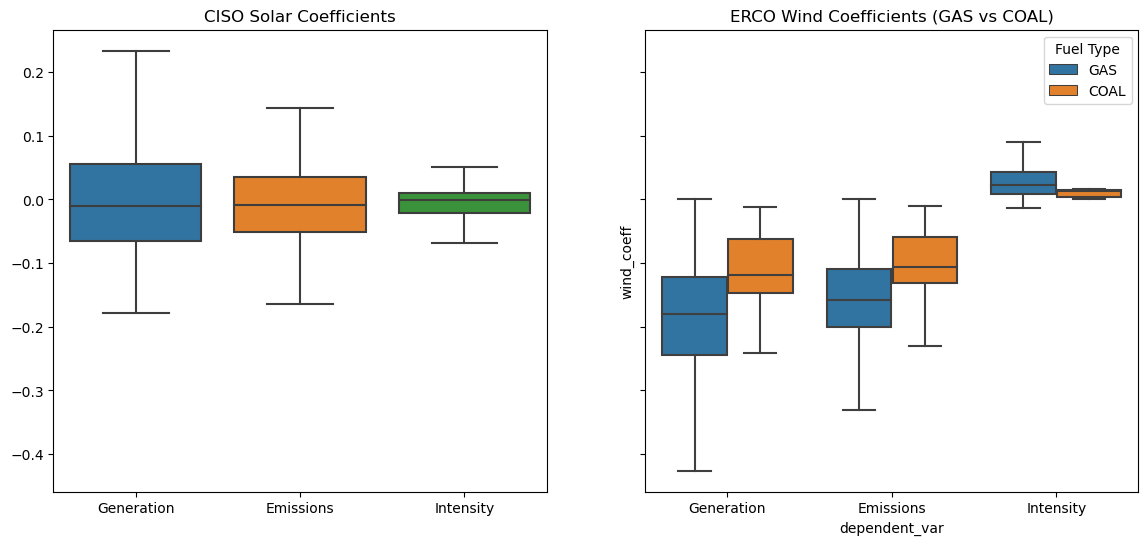

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

df_erco_analysis_G['dependent_var'] = 'Generation'
df_erco_analysis_C['dependent_var'] = 'Emissions'
df_erco_analysis_EI['dependent_var'] = 'Intensity'

# Concatenate the ERCO dataframes for plotting
df_ercot_combined = pd.concat([df_erco_analysis_G, df_erco_analysis_C, df_erco_analysis_EI])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# First subplot (CISO)
sns.boxplot(data=[df_ciso_analysis_G['solar_coeff'], df_ciso_analysis_C['solar_coeff'], 
                  df_ciso_analysis_EI['solar_coeff']], ax=ax1, showfliers = False)
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['Generation', 'Emissions', 'Intensity'])
ax1.set_title('CISO Solar Coefficients')

sns.boxplot(x='dependent_var', y='wind_coeff', hue='PLFUELCT', data=df_ercot_combined, ax=ax2,
            showfliers=False)
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['Generation', 'Emissions', 'Intensity'])
ax2.set_title('ERCO Wind Coefficients (GAS vs COAL)')
ax2.legend_.set_title('Fuel Type')

ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['Generation', 'Emissions', 'Intensity'])
ax1.set_title('CISO Solar Coefficients')

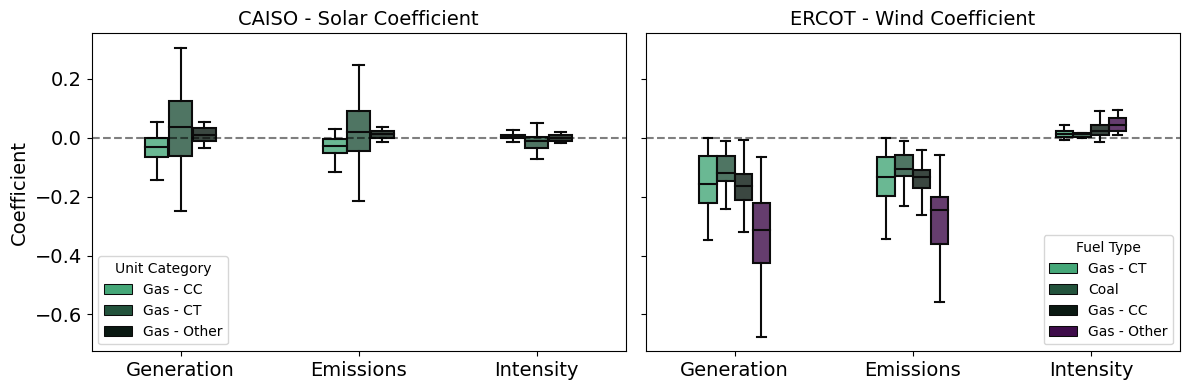

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Simulating the colors from viridis color map
colors_viridis = plt.cm.viridis(np.linspace(0, 1, 4))

# Step 1: Modify the labels for the 'Unit Category' for better clarity
df_ciso_combined['Unit Category'] = df_ciso_combined['Unit Category'].replace({
    'Combined cycle': 'Gas - CC',
    'Combustion turbine': 'Gas - CT',
    'Other': 'Gas - Other'
})

df_ercot_combined['Unit Category'] = df_ercot_combined['Unit Category'].replace({
    'Combined cycle': 'Gas - CC',
    'Combustion turbine': 'Gas - CT',
    'Other': 'Gas - Other',
    'Coal': 'Coal'
})

# Step 2: Plotting with modified order and colors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# First subplot (CISO - 3 Gas categories)
sns.boxplot(x='dependent_var', y='solar_coeff', hue='Unit Category', data=df_ciso_combined, 
            ax=ax1, showfliers=False, width=0.4, palette=sns.color_palette([colors_viridis[2], 
                                                                           colors_viridis[2] * 0.5, 
                                                                           colors_viridis[2] * 0.15]))

ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=14)
ax1.set_title('CAISO - Solar Coefficient', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Coefficient', fontsize=14)
ax1.axhline(0, color='black', alpha=0.5, linestyle='--')

# Second subplot (ERCO - 4 categories: Gas and Coal)
sns.boxplot(x='dependent_var', y='wind_coeff', hue='Unit Category', data=df_ercot_combined, 
            ax=ax2, showfliers=False, width=0.4, palette=sns.color_palette([colors_viridis[2], 
                                                                           colors_viridis[2] * 0.5, 
                                                                           colors_viridis[2] * 0.15, 
                                                                           colors_viridis[0]]))

ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=14)
ax2.set_title('ERCOT - Wind Coefficient', fontsize=14)
ax2.legend_.set_title('Fuel Type')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.axhline(0, color='black', alpha=0.5, linestyle='--')

# Adjust transparency for prettier colors
for patch in ax1.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.8))

for patch in ax2.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.8))

ax1.tick_params(axis='y', labelsize=14)

# Show the plot
plt.tight_layout()
plt.show()


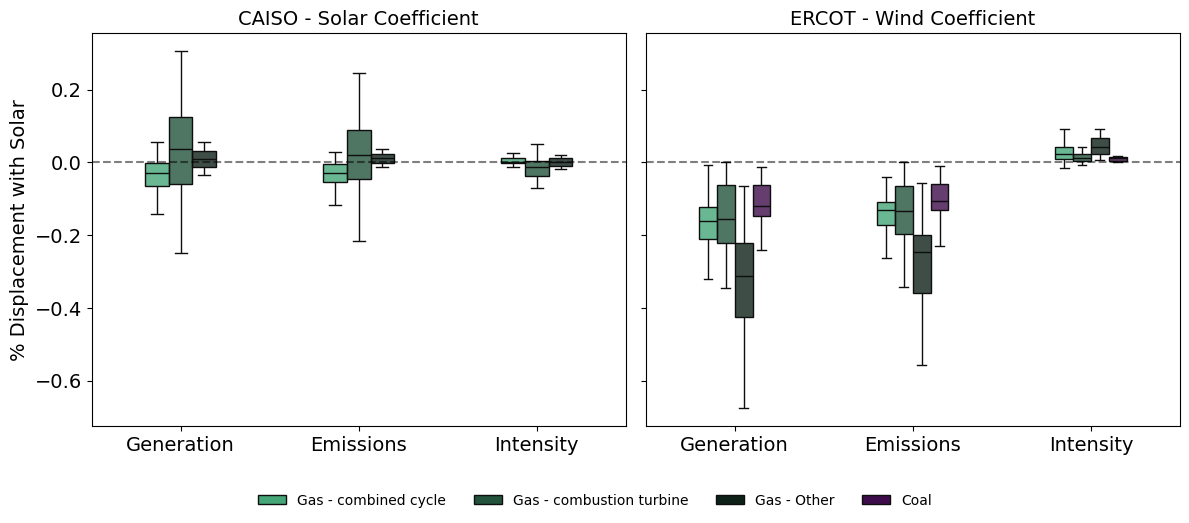

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

viridis_colors = [
    '#440154',  # Purple (dark)
    '#30678D',  # Blue
    '#35B778',  # Green
    '#FDE724'   # Yellow (light)
]

# Use these colors directly
palette = viridis_colors

# Step 1: Create a combined dataframe for CISO
df_ciso_analysis_G['dependent_var'] = 'Generation'
df_ciso_analysis_C['dependent_var'] = 'Emissions'
df_ciso_analysis_EI['dependent_var'] = 'Intensity'

# Concatenate the CISO dataframes
df_ciso_combined = pd.concat([df_ciso_analysis_G, df_ciso_analysis_C, df_ciso_analysis_EI])

# Modify 'Unit Type' column for Gas categories (Combined cycle, Combustion turbine, Other)
df_ciso_combined['Unit Category'] = df_ciso_combined.apply(
    lambda x: x['Unit Type'] if x['Unit Type'] in ['Combined cycle', 'Combustion turbine']
    else 'Other', axis=1)

# Step 2: Create a combined dataframe for ERCO
df_erco_analysis_G['dependent_var'] = 'Generation'
df_erco_analysis_C['dependent_var'] = 'Emissions'
df_erco_analysis_EI['dependent_var'] = 'Intensity'

# Concatenate the ERCO dataframes
df_ercot_combined = pd.concat([df_erco_analysis_G, df_erco_analysis_C, df_erco_analysis_EI])

# Modify 'Unit Category' for ERCO to separate Gas into three categories and leave Coal as a single category
df_ercot_combined['Unit Category'] = df_ercot_combined.apply(
    lambda x: 'Combined cycle' if x['PLFUELCT'] == 'GAS' and x['Unit Type'] == 'Combined cycle'
    else 'Combustion turbine' if x['PLFUELCT'] == 'GAS' and x['Unit Type'] == 'Combustion turbine'
    else 'Other' if x['PLFUELCT'] == 'GAS'
    else 'Coal', axis=1)

# Simulating the colors from viridis color map
colors_viridis = plt.cm.viridis(np.linspace(0, 1, 4))

# Step 1: Modify the labels for the 'Unit Category' for better clarity
df_ciso_combined['Unit Category'] = df_ciso_combined['Unit Category'].replace({
    'Combined cycle': 'Gas - combined cycle',
    'Combustion turbine': 'Gas - combustion turbine',
    'Other': 'Gas - Other'
})

df_ercot_combined['Unit Category'] = df_ercot_combined['Unit Category'].replace({
    'Combined cycle': 'Gas - combined cycle',
    'Combustion turbine': 'Gas - combustion turbine',
    'Other': 'Gas - Other',
    'Coal': 'Coal'
})

# Define a consistent color palette for both plots
palette = sns.color_palette([colors_viridis[2], colors_viridis[2] * 0.5, colors_viridis[2] * 0.2, colors_viridis[0]])

# Step 2: Plotting with modified order and colors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First subplot (CISO - 3 Gas categories, ordered as Gas - CC, Gas - CT, Gas - Other)
sns.boxplot(x='dependent_var', y='solar_coeff', hue='Unit Category', data=df_ciso_combined, 
            ax=ax1, showfliers=False, width=0.4, 
            palette=palette[:-1], hue_order=['Gas - combined cycle', 'Gas - combustion turbine', 'Gas - Other'])

ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=14)
ax1.set_title('CAISO - Solar Coefficient', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('% Displacement with Solar', fontsize=14)
ax1.axhline(0, color='black', alpha=0.5, linestyle='--')

# Second subplot (ERCO - 4 categories, with order: Gas - CT, Coal, Gas - CC, Gas - Other)
sns.boxplot(x='dependent_var', y='wind_coeff', hue='Unit Category', data=df_ercot_combined, 
            ax=ax2, showfliers=False, width=0.4, 
            palette=palette, hue_order=['Gas - combined cycle', 'Gas - combustion turbine', 'Gas - Other', 'Coal'])

ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=14)
ax2.set_title('ERCOT - Wind Coefficient', fontsize=14)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.axhline(0, color='black', alpha=0.5, linestyle='--')

# Remove individual legends
ax1.get_legend().remove()
ax2.get_legend().remove()

# Create a common legend at the bottom
handles, labels = ax2.get_legend_handles_labels()  # Get the legend from one of the plots
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05), frameon=False)

# Adjust y-axis labels
ax1.tick_params(axis='y', labelsize=14)

for patch in ax1.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.8))

for patch in ax2.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.8))

ax1.text(-0.1, 1.05, 'a', transform=ax1.transAxes, fontsize=16, fontweight='bold')
ax2.text(-0.1, 1.05, 'b', transform=ax2.transAxes, fontsize=16, fontweight='bold')

# Show the plot
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to fit the legend
plt.show()

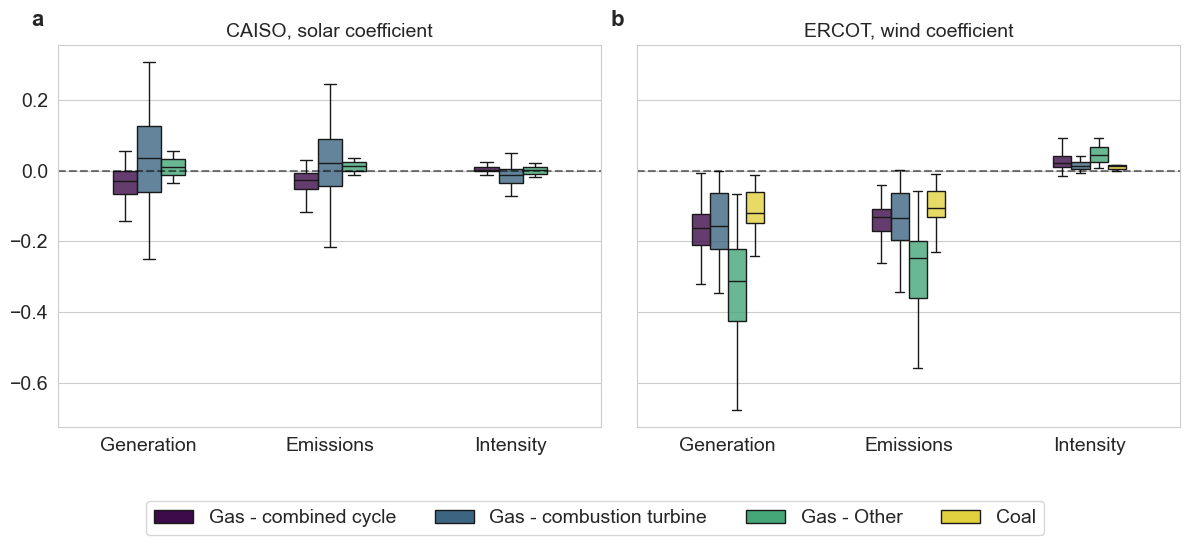

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 1: Create a combined dataframe for CISO
df_ciso_analysis_G['dependent_var'] = 'Generation'
df_ciso_analysis_C['dependent_var'] = 'Emissions'
df_ciso_analysis_EI['dependent_var'] = 'Intensity'

# Concatenate the CISO dataframes
df_ciso_combined = pd.concat([df_ciso_analysis_G, df_ciso_analysis_C, df_ciso_analysis_EI])

# Modify 'Unit Type' column for Gas categories (Combined cycle, Combustion turbine, Other)
df_ciso_combined['Unit Category'] = df_ciso_combined.apply(
    lambda x: x['Unit Type'] if x['Unit Type'] in ['Combined cycle', 'Combustion turbine']
    else 'Other', axis=1)

# Step 2: Create a combined dataframe for ERCO
df_erco_analysis_G['dependent_var'] = 'Generation'
df_erco_analysis_C['dependent_var'] = 'Emissions'
df_erco_analysis_EI['dependent_var'] = 'Intensity'

# Concatenate the ERCO dataframes
df_ercot_combined = pd.concat([df_erco_analysis_G, df_erco_analysis_C, df_erco_analysis_EI])

# Modify 'Unit Category' for ERCO to separate Gas into three categories and leave Coal as a single category
df_ercot_combined['Unit Category'] = df_ercot_combined.apply(
    lambda x: 'Combined cycle' if x['PLFUELCT'] == 'GAS' and x['Unit Type'] == 'Combined cycle'
    else 'Combustion turbine' if x['PLFUELCT'] == 'GAS' and x['Unit Type'] == 'Combustion turbine'
    else 'Other' if x['PLFUELCT'] == 'GAS'
    else 'Coal', axis=1)

# Define the first four colors of viridis
viridis_colors = [
    '#440154',  # Purple (dark)
    '#30678D',  # Blue
    '#35B778',  # Green
    '#FDE724'   # Yellow (light)
]

# Step 1: Modify the labels for the 'Unit Category' for better clarity
df_ciso_combined['Unit Category'] = df_ciso_combined['Unit Category'].replace({
    'Combined cycle': 'Gas - combined cycle',
    'Combustion turbine': 'Gas - combustion turbine',
    'Other': 'Gas - Other'
})

df_ercot_combined['Unit Category'] = df_ercot_combined['Unit Category'].replace({
    'Combined cycle': 'Gas - combined cycle',
    'Combustion turbine': 'Gas - combustion turbine',
    'Other': 'Gas - Other',
    'Coal': 'Coal'
})

# Set plot style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
sns.set_style("whitegrid")

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Add panel labels
ax1.text(-0.05, 1.05, 'a', transform=ax1.transAxes, fontsize=16, fontweight='bold')
ax2.text(-0.05, 1.05, 'b', transform=ax2.transAxes, fontsize=16, fontweight='bold')

# First subplot (CAISO - 3 Gas categories)
sns.boxplot(x='dependent_var', y='solar_coeff', hue='Unit Category', data=df_ciso_combined, 
            ax=ax1, showfliers=False, width=0.4, 
            palette=viridis_colors[:3], 
            hue_order=['Gas - combined cycle', 'Gas - combustion turbine', 'Gas - Other'])

ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=14)
ax1.set_title('CAISO, solar coefficient', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('', fontsize=14)
ax1.axhline(0, color='black', alpha=0.5, linestyle='--')
ax1.tick_params(axis='y', labelsize=14)

# Second subplot (ERCOT - 4 categories)
sns.boxplot(x='dependent_var', y='wind_coeff', hue='Unit Category', data=df_ercot_combined, 
            ax=ax2, showfliers=False, width=0.4, 
            palette=viridis_colors, 
            hue_order=['Gas - combined cycle', 'Gas - combustion turbine', 'Gas - Other', 'Coal'])

ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=14)
ax2.set_title('ERCOT, wind coefficient', fontsize=14)
ax2.set_xlabel('')
ax2.set_ylabel('')  # No y-axis label for the second plot
ax2.axhline(0, color='black', alpha=0.5, linestyle='--')
ax2.tick_params(axis='y', labelsize=14)

# Remove individual legends
ax1.get_legend().remove()
ax2.get_legend().remove()

# Create a common legend at the bottom
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1), 
           frameon=True, fontsize=14)

# Set patch transparency
for patch in ax1.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.8))

for patch in ax2.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.8))

# Adjust layout and save
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to fit the legend
plt.savefig('displacement_coefficients.pdf', bbox_inches='tight', dpi=300)
plt.savefig('displacement_coefficients.png', bbox_inches='tight', dpi=300)

plt.show()

/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_22661/2335397858.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=16)
/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_22661/2335397858.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=16)


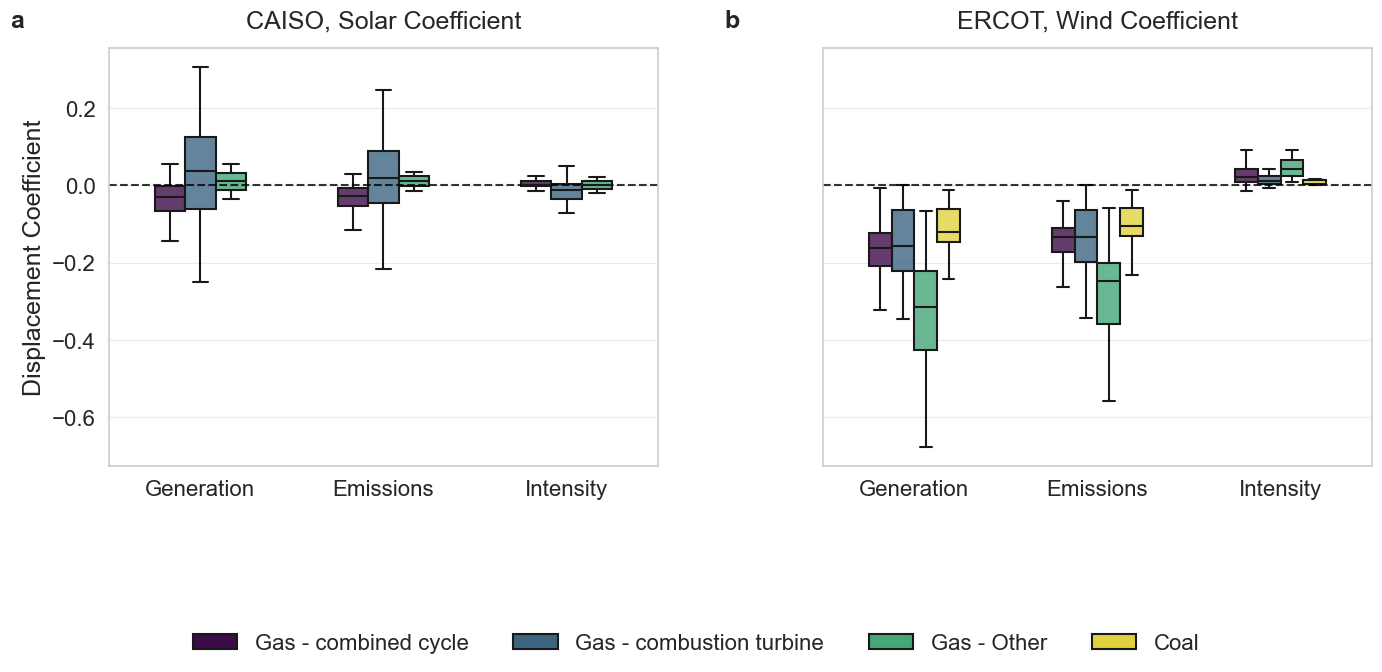

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Global Styling for Scientific (Nature) Plots ===
plt.rcParams.update({
    'font.size': 16,  # Increase global font size
    'axes.labelsize': 18,  # Increase axis label size
    'axes.titlesize': 18,  # Increase title size
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.2,  # Thicker axes
    'xtick.color': 'black',
    'ytick.color': 'black',
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'grid.alpha': 0.4  # Light grid for subtle guidance
})

# Define colors for different unit categories
viridis_colors = ['#440154', '#30678D', '#35B778', '#FDE724']

# Set plot style
sns.set_style("whitegrid")

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# === Add panel labels ('a', 'b') ===
ax1.text(-0.18, 1.05, 'a', transform=ax1.transAxes, fontsize=18, fontweight='bold')
ax2.text(-0.18, 1.05, 'b', transform=ax2.transAxes, fontsize=18, fontweight='bold')

# === First subplot: CAISO (Gas categories) ===
sns.boxplot(x='dependent_var', y='solar_coeff', hue='Unit Category', data=df_ciso_combined, 
            ax=ax1, showfliers=False, width=0.5, linewidth=1.5, 
            palette=viridis_colors[:3], 
            hue_order=['Gas - combined cycle', 'Gas - combustion turbine', 'Gas - Other'])

ax1.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=16)
ax1.set_title('CAISO, Solar Coefficient', fontsize=18, pad=15)  # Increase title spacing
ax1.set_xlabel('')
ax1.set_ylabel('Displacement Coefficient', fontsize=18)
ax1.axhline(0, color='black', alpha=0.8, linestyle='--', linewidth=1.5)  # More visible reference line
ax1.tick_params(axis='y', labelsize=16)

# === Second subplot: ERCOT (Gas + Coal) ===
sns.boxplot(x='dependent_var', y='wind_coeff', hue='Unit Category', data=df_ercot_combined, 
            ax=ax2, showfliers=False, width=0.5, linewidth=1.5, 
            palette=viridis_colors, 
            hue_order=['Gas - combined cycle', 'Gas - combustion turbine', 'Gas - Other', 'Coal'])

ax2.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=16)
ax2.set_title('ERCOT, Wind Coefficient', fontsize=18, pad=15)  # Increase title spacing
ax2.set_xlabel('')
ax2.set_ylabel('')  # No y-axis label for the second plot
ax2.axhline(0, color='black', alpha=0.8, linestyle='--', linewidth=1.5)  # More visible reference line
ax2.tick_params(axis='y', labelsize=16)

# === Remove individual legends from both plots ===
ax1.get_legend().remove()
ax2.get_legend().remove()

# === Create a common legend at the bottom ===
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.15), 
           frameon=False, fontsize=16)

# === Set transparency for box patches ===
for patch in ax1.patches + ax2.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.8))  # Slightly transparent

# === Adjust layout for better spacing ===
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Ensure legend fits well
plt.subplots_adjust(wspace=0.3)  # More spacing between subplots

# === Save the improved figure ===
plt.savefig('displacement_coefficients_nature.pdf', bbox_inches='tight', dpi=300)
plt.savefig('displacement_coefficients_nature.png', bbox_inches='tight', dpi=300)

# === Show the plot ===
plt.show()


/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_22661/1109020372.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=16)
/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_22661/1109020372.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=16)


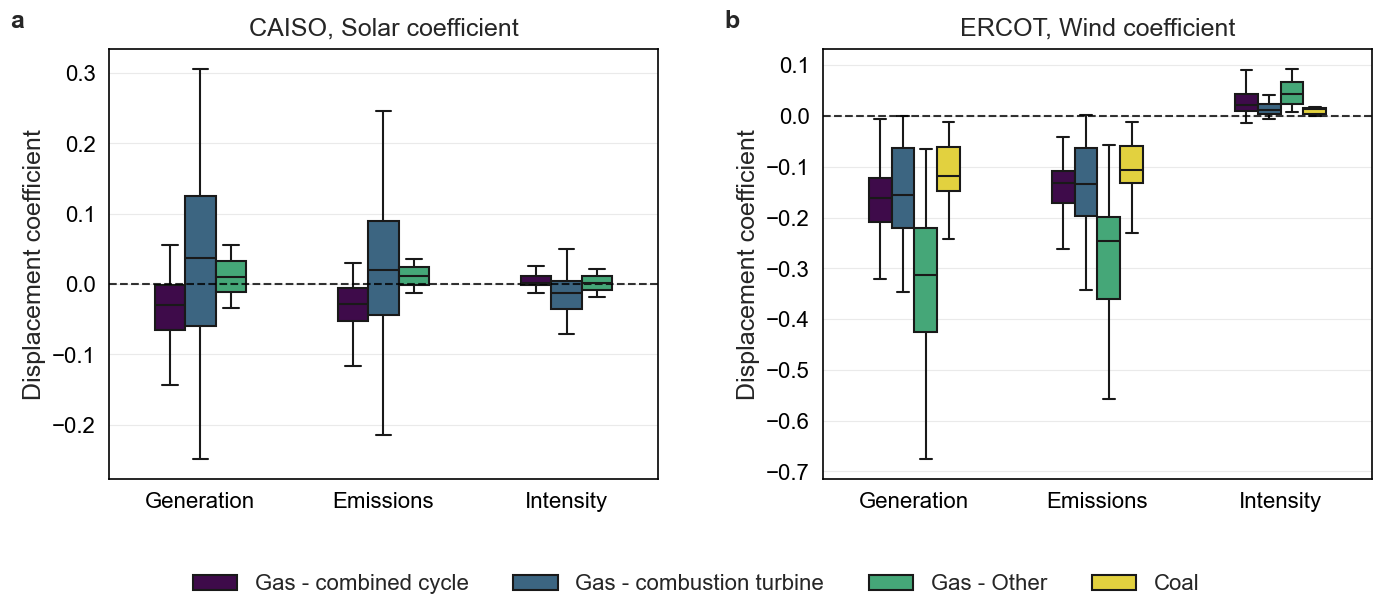

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Global Styling for Scientific (Nature) Plots ===
plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.2,  # Ensure black splines
    'xtick.color': 'black',
    'ytick.color': 'black',
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'grid.alpha': 0.4  # Keep a subtle grid for readability
})

# Define colors for different unit categories
viridis_colors = ['#440154', '#30678D', '#35B778', '#FDE724']

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# === Add panel labels ('a', 'b') ===
ax1.text(-0.18, 1.05, 'a', transform=ax1.transAxes, fontsize=18, fontweight='bold')
ax2.text(-0.18, 1.05, 'b', transform=ax2.transAxes, fontsize=18, fontweight='bold')

# === First subplot: CAISO (Gas categories) ===
sns.boxplot(x='dependent_var', y='solar_coeff', hue='Unit Category', data=df_ciso_combined, 
            ax=ax1, showfliers=False, width=0.5, linewidth=1.5, 
            palette=viridis_colors[:3], 
            hue_order=['Gas - combined cycle', 'Gas - combustion turbine', 'Gas - Other'])

ax1.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=16)
ax1.set_title('CAISO, Solar coefficient', fontsize=18, pad=10)  # Title correction
ax1.set_xlabel('')
ax1.set_ylabel('Displacement coefficient', fontsize=18)  # Y-axis label
ax1.axhline(0, color='black', alpha=0.8, linestyle='--', linewidth=1.5)  # Bold zero-reference line
ax1.tick_params(axis='y', labelsize=16)

# Set **black** axis spines for a professional look
for spine in ax1.spines.values():
    spine.set_color('black')

# === Second subplot: ERCOT (Gas + Coal) ===
sns.boxplot(x='dependent_var', y='wind_coeff', hue='Unit Category', data=df_ercot_combined, 
            ax=ax2, showfliers=False, width=0.5, linewidth=1.5, 
            palette=viridis_colors, 
            hue_order=['Gas - combined cycle', 'Gas - combustion turbine', 'Gas - Other', 'Coal'])

ax2.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=16)
ax2.set_title('ERCOT, Wind coefficient', fontsize=18, pad=10)  # Title correction
ax2.set_xlabel('')
ax2.set_ylabel('Displacement coefficient', fontsize=18)  # Y-axis label added to match ax1
ax2.axhline(0, color='black', alpha=0.8, linestyle='--', linewidth=1.5)  # Bold zero-reference line
ax2.tick_params(axis='y', labelsize=16)

# Set **black** axis spines for a professional look
for spine in ax2.spines.values():
    spine.set_color('black')

# === Remove individual legends ===
ax1.get_legend().remove()
ax2.get_legend().remove()

# === Create a common legend at the bottom, slightly closer to the figure ===
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05),  # Adjusted closer
           frameon=False, fontsize=16)

# === Adjust layout to reduce bottom spacing ===
plt.tight_layout(rect=[0, 0.08, 1, 1])  # Brings legend closer to figure
plt.subplots_adjust(wspace=0.3)  # Increase spacing between subplots

# === Save the improved figure ===
plt.savefig('displacement_coefficients_nature.pdf', bbox_inches='tight', dpi=300)
plt.savefig('displacement_coefficients_nature.png', bbox_inches='tight', dpi=300)

# === Show the plot ===
plt.show()


/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_22661/2578618217.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=16)
/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_22661/2578618217.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=16)


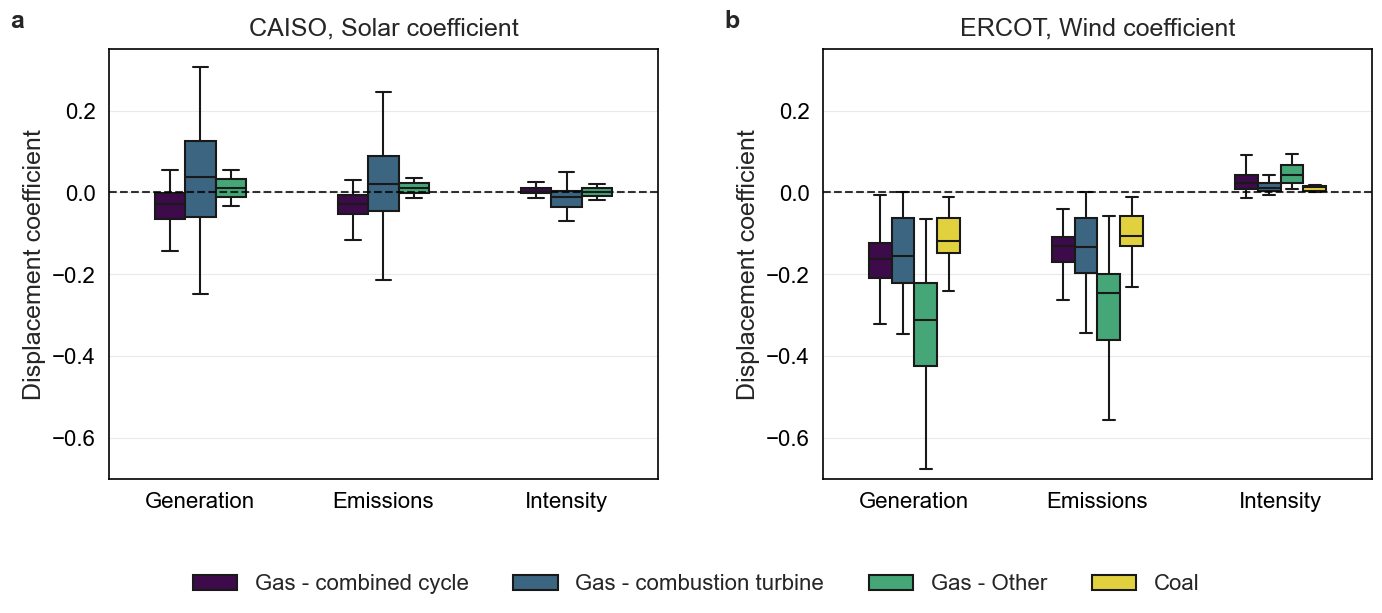

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Global Styling for Scientific (Nature) Plots ===
plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.2,  # Ensure black splines
    'xtick.color': 'black',
    'ytick.color': 'black',
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'grid.alpha': 0.4  # Keep a subtle grid for readability
})

# Define colors for different unit categories
viridis_colors = ['#440154', '#30678D', '#35B778', '#FDE724']

# Create figure with subplots (DO NOT SHARE Y-AXIS)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# === Add panel labels ('a', 'b') ===
ax1.text(-0.18, 1.05, 'a', transform=ax1.transAxes, fontsize=18, fontweight='bold')
ax2.text(-0.18, 1.05, 'b', transform=ax2.transAxes, fontsize=18, fontweight='bold')

# === First subplot: CAISO (Gas categories) ===
sns.boxplot(x='dependent_var', y='solar_coeff', hue='Unit Category', data=df_ciso_combined, 
            ax=ax1, showfliers=False, width=0.5, linewidth=1.5, 
            palette=viridis_colors[:3], 
            hue_order=['Gas - combined cycle', 'Gas - combustion turbine', 'Gas - Other'])

ax1.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=16)
ax1.set_title('CAISO, Solar coefficient', fontsize=18, pad=10)  # Title correction
ax1.set_xlabel('')
ax1.set_ylabel('Displacement coefficient', fontsize=18)  # Y-axis label
ax1.axhline(0, color='black', alpha=0.8, linestyle='--', linewidth=1.5)  # Bold zero-reference line
ax1.tick_params(axis='y', labelsize=16)

# Set **black** axis spines for a professional look
for spine in ax1.spines.values():
    spine.set_color('black')

# === Second subplot: ERCOT (Gas + Coal) ===
sns.boxplot(x='dependent_var', y='wind_coeff', hue='Unit Category', data=df_ercot_combined, 
            ax=ax2, showfliers=False, width=0.5, linewidth=1.5, 
            palette=viridis_colors, 
            hue_order=['Gas - combined cycle', 'Gas - combustion turbine', 'Gas - Other', 'Coal'])

ax2.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=16)
ax2.set_title('ERCOT, Wind coefficient', fontsize=18, pad=10)  # Title correction
ax2.set_xlabel('')
ax2.set_ylabel('Displacement coefficient', fontsize=18)  # Y-axis label added to match ax1
ax2.axhline(0, color='black', alpha=0.8, linestyle='--', linewidth=1.5)  # Bold zero-reference line
ax2.tick_params(axis='y', labelsize=16)

# Set **black** axis spines for a professional look
for spine in ax2.spines.values():
    spine.set_color('black')

# === Set consistent y-axis limits across both subplots ===
y_min = -0.7
y_max = 0.35

ax1.set_ylim(y_min, y_max)
ax2.set_ylim(y_min, y_max)

# === Remove individual legends ===
ax1.get_legend().remove()
ax2.get_legend().remove()

# === Create a common legend at the bottom, slightly closer to the figure ===
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05),  # Adjusted closer
           frameon=False, fontsize=16)

# === Adjust layout to reduce bottom spacing ===
plt.tight_layout(rect=[0, 0.08, 1, 1])  # Brings legend closer to figure
plt.subplots_adjust(wspace=0.3)  # Increase spacing between subplots

# === Save the improved figure ===
plt.savefig('displacement_coefficients_nature.pdf', bbox_inches='tight', dpi=300)
plt.savefig('displacement_coefficients_nature.png', bbox_inches='tight', dpi=300)

# === Show the plot ===
plt.show()


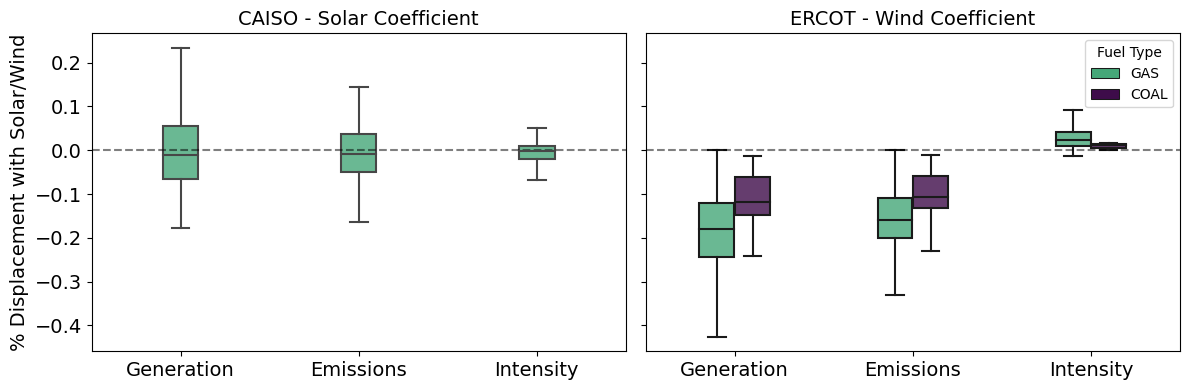

In [18]:
# Adjusting the plot according to the new requirements

# Recreating the necessary plot with the requested modifications
import numpy as np

# Simulating the colors from viridis color map
colors_viridis = plt.cm.viridis(np.linspace(0, 1, 4))

# Plot the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# First subplot (CISO)
sns.boxplot(data=[df_ciso_analysis_G['solar_coeff'], df_ciso_analysis_C['solar_coeff'], 
                  df_ciso_analysis_EI['solar_coeff']], ax=ax1, showfliers=False, width=0.2, 
            color=colors_viridis[2])

ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=14)
ax1.set_title('CAISO - Solar Coefficient', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('')

# Second subplot (ERCO)
sns.boxplot(x='dependent_var', y='wind_coeff', hue='PLFUELCT', data=df_ercot_combined, 
            ax=ax2, showfliers=False, width=0.4, palette=[colors_viridis[2], colors_viridis[0]])

ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['Generation', 'Emissions', 'Intensity'], fontsize=14)
ax2.set_title('ERCOT - Wind Coefficient', fontsize=14)
ax2.legend_.set_title('Fuel Type')
ax2.set_xlabel('')
ax2.set_ylabel('')

# Remove y-labels for both plots
ax1.set_ylabel('% Displacement with Solar/Wind', fontsize=14)
ax2.set_ylabel('')

ax1.axhline(0, color='black', alpha=0.5, linestyle='--')
ax2.axhline(0, color='black', alpha=0.5, linestyle='--')

for patch in ax1.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r,g,b,0.8))

for patch in ax2.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r,g,b,0.8))

ax1.tick_params(axis='y',labelsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [19]:
df_ciso_analysis_G.columns

Index(['id', 'rsquared', 'residual_demand_coeff', 'residual_demand_std',
       'solar_coeff', 'solar_std', 'solar_sig', 'wind_coeff', 'wind_std',
       'wind_sig', 'wramp_coeff', 'wramp_std', 'wramp_sig', 'PSTATABB',
       'BACODE', 'ISORTO', 'LAT', 'LON', 'PLPRMFL', 'PLFUELCT', 'CAPFAC',
       'NAMEPCAP', 'CHPFLAG', 'PLNGENAN', 'PLNOXAN', 'PLSO2AN', 'PLCO2AN',
       'PLHTRT', 'NOXEI', 'SO2EI', 'CO2EI', 'Unit Type', 'dependent_var'],
      dtype='object')

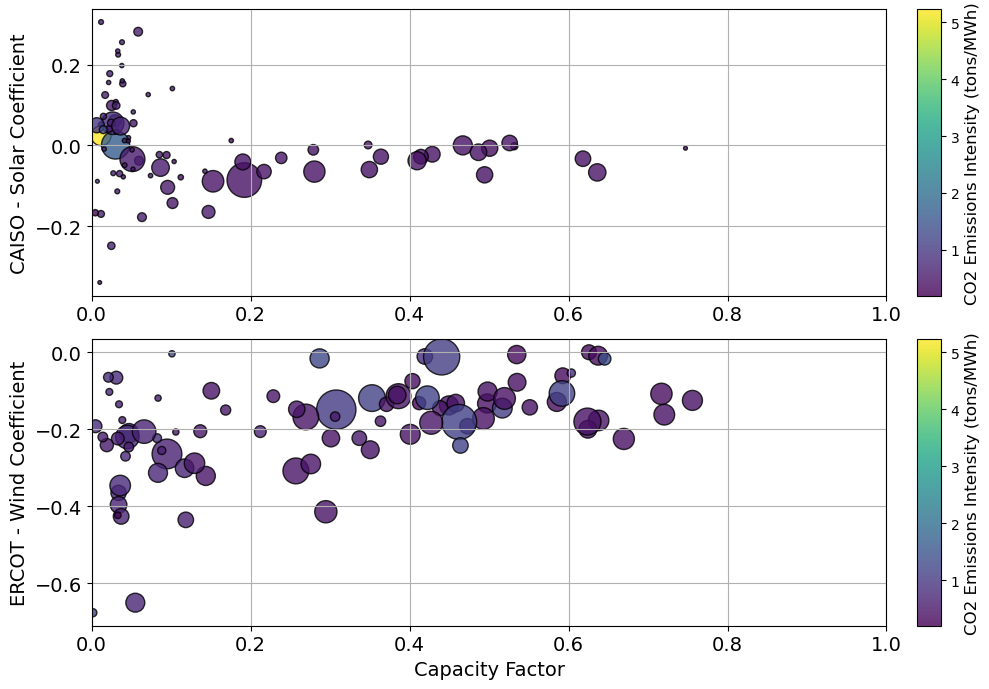

In [20]:
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Determine the global minimum and maximum CO2 Emissions Intensity for both datasets
global_min_CO2EI = min(df_ciso_analysis_G.CO2EI.min(), df_erco_analysis_G.CO2EI.min())
global_max_CO2EI = max(df_ciso_analysis_G.CO2EI.max(), df_erco_analysis_G.CO2EI.max())

# Create figure and subplots using gridspec for custom layout
fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[5, 0.15], height_ratios=[1,1])

# CISO Solar Coefficient Plot
ax0 = fig.add_subplot(gs[0, 0])  # First row, first column
solar_scatter = ax0.scatter(
    df_ciso_analysis_G.CAPFAC,
    df_ciso_analysis_G.solar_coeff,
    s=df_ciso_analysis_G.NAMEPCAP / 5,
    c=df_ciso_analysis_G.CO2EI,
    cmap="viridis",
    alpha=0.8,
    edgecolor="black",
    vmin=global_min_CO2EI,  # Use global min and max for color normalization
    vmax=global_max_CO2EI
)
ax0.set_ylabel("CAISO - Solar Coefficient", fontsize=14)
ax0.set_xlim(0, 1)  # Ensure shared x-axis range
ax0.grid()

# ERCOT Wind Coefficient Plot
ax1 = fig.add_subplot(gs[1, 0])  # Second row, first column
wind_scatter = ax1.scatter(
    df_erco_analysis_G.CAPFAC,
    df_erco_analysis_G.wind_coeff,
    s=df_erco_analysis_G.NAMEPCAP / 5,
    c=df_erco_analysis_G.CO2EI,
    cmap="viridis",
    alpha=0.8,
    edgecolor="black",
    vmin=global_min_CO2EI,  # Use global min and max for color normalization
    vmax=global_max_CO2EI
)
ax1.set_xlabel("Capacity Factor", fontsize=14)
ax1.set_ylabel("ERCOT - Wind Coefficient", fontsize=14)
ax1.set_xlim(0, 1)  # Explicitly set here for clarity
ax1.grid()

# Add colorbars adjacent to each plot, with normalized limits
cbar_ax0 = fig.add_subplot(gs[0, 1])  # For CAISO
cbar0 = fig.colorbar(solar_scatter, cax=cbar_ax0, orientation='vertical')
cbar0.set_label("CO2 Emissions Intensity (tons/MWh)", fontsize=12)

cbar_ax1 = fig.add_subplot(gs[1, 1])  # For ERCOT
cbar1 = fig.colorbar(wind_scatter, cax=cbar_ax1, orientation='vertical')
cbar1.set_label("CO2 Emissions Intensity (tons/MWh)", fontsize=12)

ax0.tick_params(axis='y',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax0.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='x',labelsize=14)

fig.tight_layout()
plt.show()

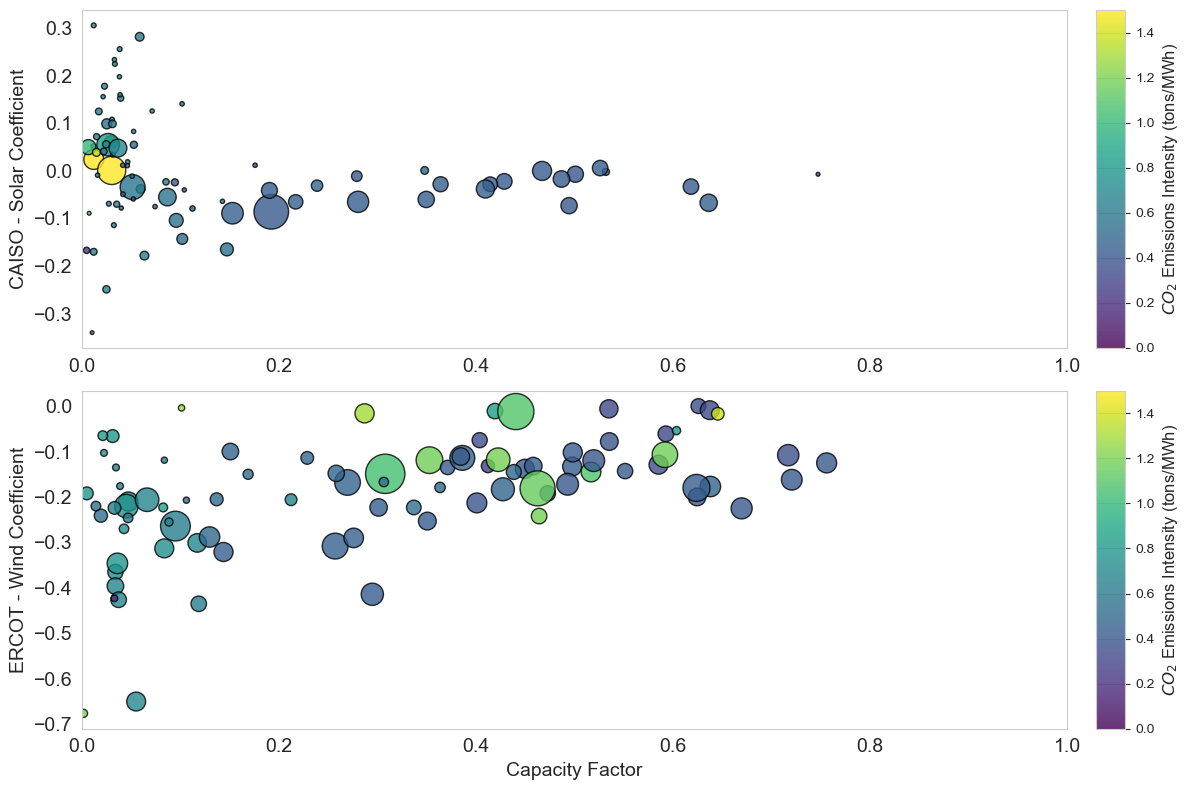

In [20]:
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

# Determine the global minimum and maximum CO2 Emissions Intensity for both datasets
global_min_CO2EI = 0  # Set the minimum explicitly to 0 for clipping
global_max_CO2EI = 1.5  # Set the maximum explicitly to 2 for clipping

# Create figure and subplots using gridspec for custom layout
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[5, 0.15], height_ratios=[1, 1])

# Create the normalization for the color scale (clipping between 0 and 2)
norm = Normalize(vmin=global_min_CO2EI, vmax=global_max_CO2EI)

# CISO Solar Coefficient Plot
ax0 = fig.add_subplot(gs[0, 0])  # First row, first column
solar_scatter = ax0.scatter(
    df_ciso_analysis_G.CAPFAC,
    df_ciso_analysis_G.solar_coeff,
    s=df_ciso_analysis_G.NAMEPCAP / 5,
    c=df_ciso_analysis_G.CO2EI,
    cmap="viridis",
    alpha=0.8,
    edgecolor="black",
    norm=norm  # Apply the clipping normalization
)
ax0.set_ylabel("CAISO - Solar Coefficient", fontsize=14)
ax0.set_xlim(0, 1)  # Ensure shared x-axis range
ax0.grid()

# ERCOT Wind Coefficient Plot
ax1 = fig.add_subplot(gs[1, 0])  # Second row, first column
wind_scatter = ax1.scatter(
    df_erco_analysis_G.CAPFAC,
    df_erco_analysis_G.wind_coeff,
    s=df_erco_analysis_G.NAMEPCAP / 5,
    c=df_erco_analysis_G.CO2EI,
    cmap="viridis",
    alpha=0.8,
    edgecolor="black",
    norm=norm  # Apply the clipping normalization
)
ax1.set_xlabel("Capacity Factor", fontsize=14)
ax1.set_ylabel("ERCOT - Wind Coefficient", fontsize=14)
ax1.set_xlim(0, 1)  # Explicitly set here for clarity
ax1.grid()

# Add colorbars adjacent to each plot, with normalized limits
cbar_ax0 = fig.add_subplot(gs[0, 1])  # For CAISO
cbar0 = fig.colorbar(solar_scatter, cax=cbar_ax0, orientation='vertical')
cbar0.set_label(r"$CO_2$ Emissions Intensity (tons/MWh)", fontsize=12)  # CO2 with subscript

cbar_ax1 = fig.add_subplot(gs[1, 1])  # For ERCOT
cbar1 = fig.colorbar(wind_scatter, cax=cbar_ax1, orientation='vertical')
cbar1.set_label(r"$CO_2$ Emissions Intensity (tons/MWh)", fontsize=12)  # CO2 with subscript

# Adjust font sizes for tick parameters
ax0.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax0.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plot
plt.show()


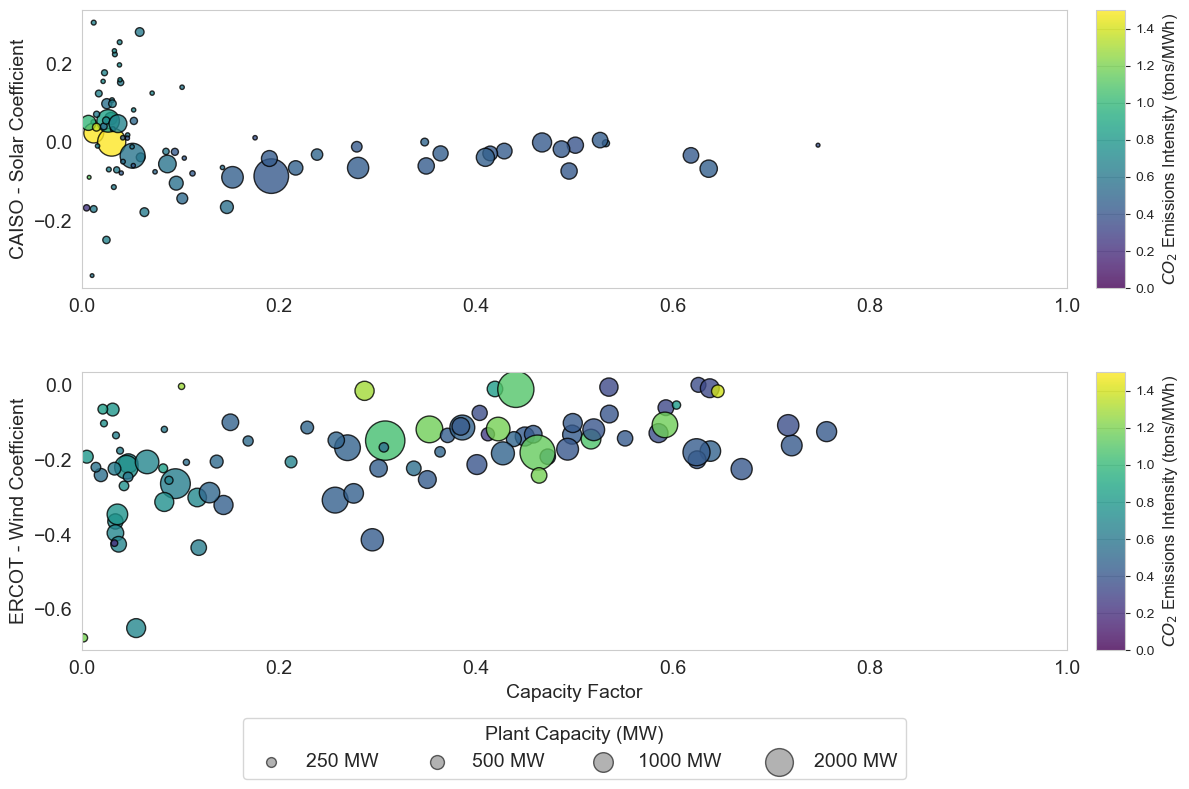

In [21]:
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
import matplotlib.lines as mlines

# Determine the global minimum and maximum CO2 Emissions Intensity for both datasets
global_min_CO2EI = 0  # Set the minimum explicitly to 0 for clipping
global_max_CO2EI = 1.5  # Set the maximum explicitly to 1.5 for clipping

# Create figure and subplots using gridspec for custom layout
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(3, 2, width_ratios=[5, 0.15], height_ratios=[1, 1, 0.1])

# Create the normalization for the color scale (clipping between 0 and 1.5)
norm = Normalize(vmin=global_min_CO2EI, vmax=global_max_CO2EI)

# CISO Solar Coefficient Plot
ax0 = fig.add_subplot(gs[0, 0])  # First row, first column
solar_scatter = ax0.scatter(
    df_ciso_analysis_G.CAPFAC,
    df_ciso_analysis_G.solar_coeff,
    s=df_ciso_analysis_G.NAMEPCAP / 5,
    c=df_ciso_analysis_G.CO2EI,
    cmap="viridis",
    alpha=0.8,
    edgecolor="black",
    norm=norm  # Apply the clipping normalization
)
ax0.set_ylabel("CAISO - Solar Coefficient", fontsize=14)
ax0.set_xlim(0, 1)  # Ensure shared x-axis range
ax0.grid()

# ERCOT Wind Coefficient Plot
ax1 = fig.add_subplot(gs[1, 0])  # Second row, first column
wind_scatter = ax1.scatter(
    df_erco_analysis_G.CAPFAC,
    df_erco_analysis_G.wind_coeff,
    s=df_erco_analysis_G.NAMEPCAP / 5,
    c=df_erco_analysis_G.CO2EI,
    cmap="viridis",
    alpha=0.8,
    edgecolor="black",
    norm=norm  # Apply the clipping normalization
)
ax1.set_xlabel("Capacity Factor", fontsize=14)
ax1.set_ylabel("ERCOT - Wind Coefficient", fontsize=14)
ax1.set_xlim(0, 1)  # Explicitly set here for clarity
ax1.grid()

# Add colorbars adjacent to each plot, with normalized limits
cbar_ax0 = fig.add_subplot(gs[0, 1])  # For CAISO
cbar0 = fig.colorbar(solar_scatter, cax=cbar_ax0, orientation='vertical')
cbar0.set_label(r"$CO_2$ Emissions Intensity (tons/MWh)", fontsize=12)  # CO2 with subscript

cbar_ax1 = fig.add_subplot(gs[1, 1])  # For ERCOT
cbar1 = fig.colorbar(wind_scatter, cax=cbar_ax1, orientation='vertical')
cbar1.set_label(r"$CO_2$ Emissions Intensity (tons/MWh)", fontsize=12)  # CO2 with subscript

# Create marker size legend (at the bottom)
ax2 = fig.add_subplot(gs[2, 0])  # Empty plot to place the size legend
ax2.axis('off')  # Hide the axis

# Marker sizes for the legend
sizes = [50, 100, 200, 400]  # Adjust the values as per your dataset
labels = [f'{size * 5} MW' for size in sizes]  # Assuming size scaling is NAMEPCAP / 5

# Create dummy scatter plots for legend
for size, label in zip(sizes, labels):
    ax2.scatter([], [], s=size, edgecolor='black', facecolor='gray', label=label, alpha=0.6)

# Create the legend
ax2.legend(loc='center', title='Plant Capacity (MW)', scatterpoints=1, fontsize=14, title_fontsize=14, ncol=4)

# Adjust font sizes for tick parameters
ax0.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax0.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plot
plt.show()


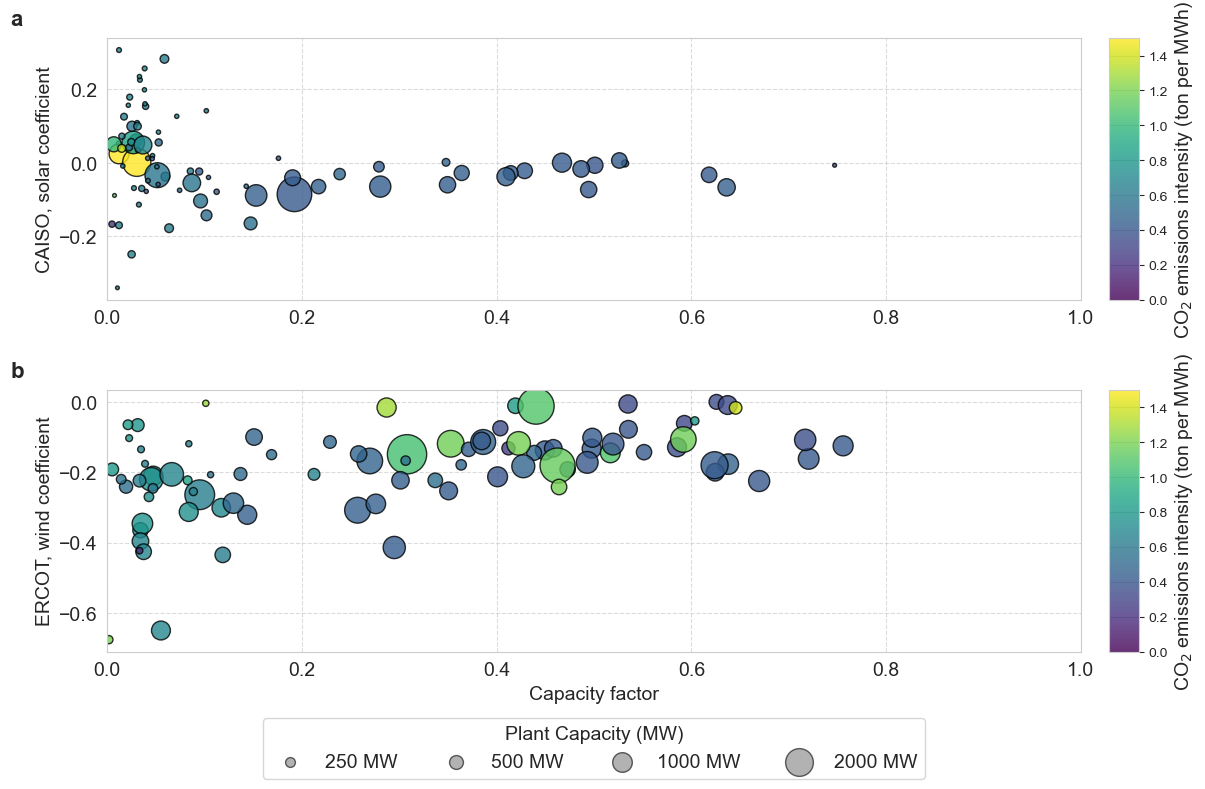

In [30]:
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
import matplotlib.lines as mlines

# Determine the global minimum and maximum CO2 Emissions Intensity for both datasets
global_min_CO2EI = 0  # Set the minimum explicitly to 0 for clipping
global_max_CO2EI = 1.5  # Set the maximum explicitly to 1.5 for clipping

# Create figure and subplots using gridspec for custom layout
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(3, 2, width_ratios=[5, 0.15], height_ratios=[1, 1, 0.05])

# Create the normalization for the color scale (clipping between 0 and 1.5)
norm = Normalize(vmin=global_min_CO2EI, vmax=global_max_CO2EI)

# CISO Solar Coefficient Plot
ax0 = fig.add_subplot(gs[0, 0])  # First row, first column
solar_scatter = ax0.scatter(
    df_ciso_analysis_G.CAPFAC,
    df_ciso_analysis_G.solar_coeff,
    s=df_ciso_analysis_G.NAMEPCAP / 5,
    c=df_ciso_analysis_G.CO2EI,
    cmap="viridis",
    alpha=0.8,
    edgecolor="black",
    norm=norm  # Apply the clipping normalization
)
ax0.set_ylabel("CAISO, solar coefficient", fontsize=14)  # Updated label
ax0.set_xlim(0, 1)  # Ensure shared x-axis range
ax0.grid(True, linestyle='--', alpha=0.7)  # Show gridlines

# Add 'a' label to the top left of the first plot
ax0.text(-0.1, 1.05, 'a', transform=ax0.transAxes, fontsize=16, fontweight='bold')

# ERCOT Wind Coefficient Plot
ax1 = fig.add_subplot(gs[1, 0])  # Second row, first column
wind_scatter = ax1.scatter(
    df_erco_analysis_G.CAPFAC,
    df_erco_analysis_G.wind_coeff,
    s=df_erco_analysis_G.NAMEPCAP / 5,
    c=df_erco_analysis_G.CO2EI,
    cmap="viridis",
    alpha=0.8,
    edgecolor="black",
    norm=norm  # Apply the clipping normalization
)
ax1.set_xlabel("Capacity factor", fontsize=14)  # Lowercase 'f'
ax1.set_ylabel("ERCOT, wind coefficient", fontsize=14)  # Updated label
ax1.set_xlim(0, 1)  # Explicitly set here for clarity
ax1.grid(True, linestyle='--', alpha=0.7)  # Show gridlines

# Add 'b' label to the top left of the second plot
ax1.text(-0.1, 1.05, 'b', transform=ax1.transAxes, fontsize=16, fontweight='bold')

# Add colorbars adjacent to each plot, with normalized limits
cbar_ax0 = fig.add_subplot(gs[0, 1])  # For CAISO
cbar0 = fig.colorbar(solar_scatter, cax=cbar_ax0, orientation='vertical')
cbar0.set_label(r"CO$_2$ emissions intensity (ton per MWh)", fontsize=14)  # Updated label

cbar_ax1 = fig.add_subplot(gs[1, 1])  # For ERCOT
cbar1 = fig.colorbar(wind_scatter, cax=cbar_ax1, orientation='vertical')
cbar1.set_label(r"CO$_2$ emissions intensity (ton per MWh)", fontsize=14)  # Updated label

# Create marker size legend (at the bottom)
ax2 = fig.add_subplot(gs[2, 0])  # Empty plot to place the size legend
ax2.axis('off')  # Hide the axis

# Marker sizes for the legend
sizes = [50, 100, 200, 400]  # Adjust the values as per your dataset
labels = [f'{size * 5} MW' for size in sizes]  # Assuming size scaling is NAMEPCAP / 5

# Create dummy scatter plots for legend
for size, label in zip(sizes, labels):
    ax2.scatter([], [], s=size, edgecolor='black', facecolor='gray', label=label, alpha=0.6)

# Create the legend
ax2.legend(loc='center', title='Plant Capacity (MW)', scatterpoints=1, fontsize=14, title_fontsize=14, ncol=4)

# Adjust font sizes for tick parameters
ax0.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax0.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()


# Save the figure
plt.savefig('displacement_coefficients_scatter.pdf', bbox_inches='tight', dpi=300)
plt.savefig('displacement_coefficients_scatter.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

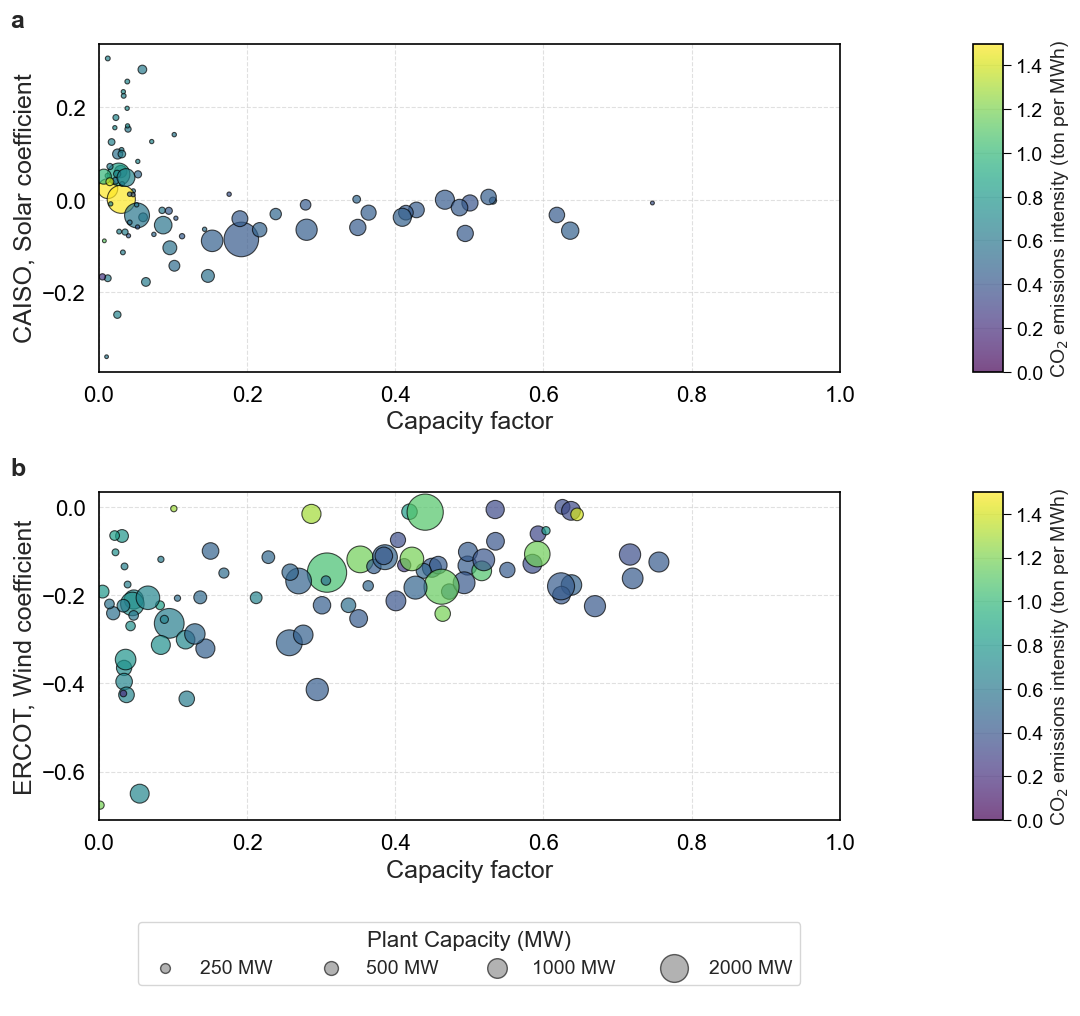

In [48]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

# === Global Styling for Scientific (Nature) Plots ===
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.2,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'grid.alpha': 0.4
})

# Define global min/max CO2 emissions intensity for normalization
global_min_CO2EI = 0
global_max_CO2EI = 1.5

# Create figure with gridspec layout
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 3, width_ratios=[5, 0.2, 0.2], height_ratios=[1, 1, 0.2])

# Normalize color scale
norm = Normalize(vmin=global_min_CO2EI, vmax=global_max_CO2EI)

# === Scatter Plot: CAISO (Solar Coefficient) ===
ax0 = fig.add_subplot(gs[0, 0])
solar_scatter = ax0.scatter(
    df_ciso_analysis_G.CAPFAC,
    df_ciso_analysis_G.solar_coeff,
    s=df_ciso_analysis_G.NAMEPCAP / 5,
    c=df_ciso_analysis_G.CO2EI,
    cmap="viridis",
    alpha=0.7,  # Slight transparency for clarity
    edgecolor="black",
    linewidth=0.8,  # Thinner edge lines
    norm=norm
)
ax0.set_xlabel("Capacity factor", fontsize=18)
ax0.set_ylabel("CAISO, Solar coefficient", fontsize=18)
ax0.set_xlim(0, 1)
ax0.grid(True, linestyle='--', alpha=0.6)

# Add panel label
ax0.text(-0.12, 1.05, 'a', transform=ax0.transAxes, fontsize=18, fontweight='bold')

# === Scatter Plot: ERCOT (Wind Coefficient) ===
ax1 = fig.add_subplot(gs[1, 0])
wind_scatter = ax1.scatter(
    df_erco_analysis_G.CAPFAC,
    df_erco_analysis_G.wind_coeff,
    s=df_erco_analysis_G.NAMEPCAP / 5,
    c=df_erco_analysis_G.CO2EI,
    cmap="viridis",
    alpha=0.7,  # Consistent transparency
    edgecolor="black",
    linewidth=0.8,
    norm=norm
)
ax1.set_xlabel("Capacity factor", fontsize=18)
ax1.set_ylabel("ERCOT, Wind coefficient", fontsize=18)
ax1.set_xlim(0, 1)
ax1.grid(True, linestyle='--', alpha=0.6)

# Add panel label
ax1.text(-0.12, 1.05, 'b', transform=ax1.transAxes, fontsize=18, fontweight='bold')

# === Colorbar for CAISO (aligned properly) ===
cbar_ax0 = fig.add_subplot(gs[0, 1])
cbar0 = fig.colorbar(solar_scatter, cax=cbar_ax0, orientation='vertical')
cbar0.set_label(r"CO$_2$ emissions intensity (ton per MWh)", fontsize=14)
cbar0.ax.tick_params(labelsize=14)

# === Colorbar for ERCOT (aligned properly) ===
cbar_ax1 = fig.add_subplot(gs[1, 1])
cbar1 = fig.colorbar(wind_scatter, cax=cbar_ax1, orientation='vertical')
cbar1.set_label(r"CO$_2$ emissions intensity (ton per MWh)", fontsize=14)
cbar1.ax.tick_params(labelsize=14)

# === Plant Capacity Legend (Bottom) ===
ax2 = fig.add_subplot(gs[2, 0])
ax2.axis('off')  # Hide axis

# Define marker sizes and labels for legend
sizes = [50, 100, 200, 400]
labels = [f'{size * 5} MW' for size in sizes]

# Create dummy scatter points for the legend
for size, label in zip(sizes, labels):
    ax2.scatter([], [], s=size, edgecolor='black', facecolor='gray', label=label, alpha=0.6)

# Create the legend, adjusted to avoid overlap
ax2.legend(
    loc='center', title='Plant Capacity (MW)',
    scatterpoints=1, fontsize=14, title_fontsize=16,
    ncol=4, bbox_to_anchor=(0.5, 0.8)  # Moves legend **above x-axis**
)

# === Adjust font sizes for axis ticks ===
ax0.tick_params(axis='both', labelsize=16)
ax1.tick_params(axis='both', labelsize=16)

# === Adjust layout to prevent overlap ===
plt.tight_layout(rect=[0, 0.12, 1, 1])  # Adjust bottom space
plt.subplots_adjust(hspace=0.5, wspace=0.5, bottom=0.15)  # Increased spacing for colorbars

# === Save figure ===
plt.savefig('displacement_coefficients_scatter_nature.pdf', bbox_inches='tight', dpi=300)
plt.savefig('displacement_coefficients_scatter_nature.png', bbox_inches='tight', dpi=300)

# === Show plot ===
plt.show()


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import random
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap

# load plot setting parameters
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 17.5})
# plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['axes.titlepad'] = 15

In [66]:
df_ciso_analysis = analyze_energy_data(
    'C:/Users/surid/data/emissionsimpacts/processed/CISO_merged_H.csv',
    'C:/Users/surid/data/emissionsimpacts/processed/CISO_control.csv',
    'C:/Users/surid/data/emissionsimpacts/egrid/eGRID2020_Data_v2.xlsx',
    'CISO',
    ['GAS', 'OIL', 'COAL']
)

In [3]:
df_erco_analysis = analyze_energy_data(
    'C:/Users/surid/data/emissionsimpacts/processed/ERCO_merged_H.csv',
    'C:/Users/surid/data/emissionsimpacts/processed/ERCO_control.csv',
    'C:/Users/surid/data/emissionsimpacts/egrid/eGRID2020_Data_v2.xlsx',
    'ERCO',
    ['GAS', 'OIL', 'COAL']
)

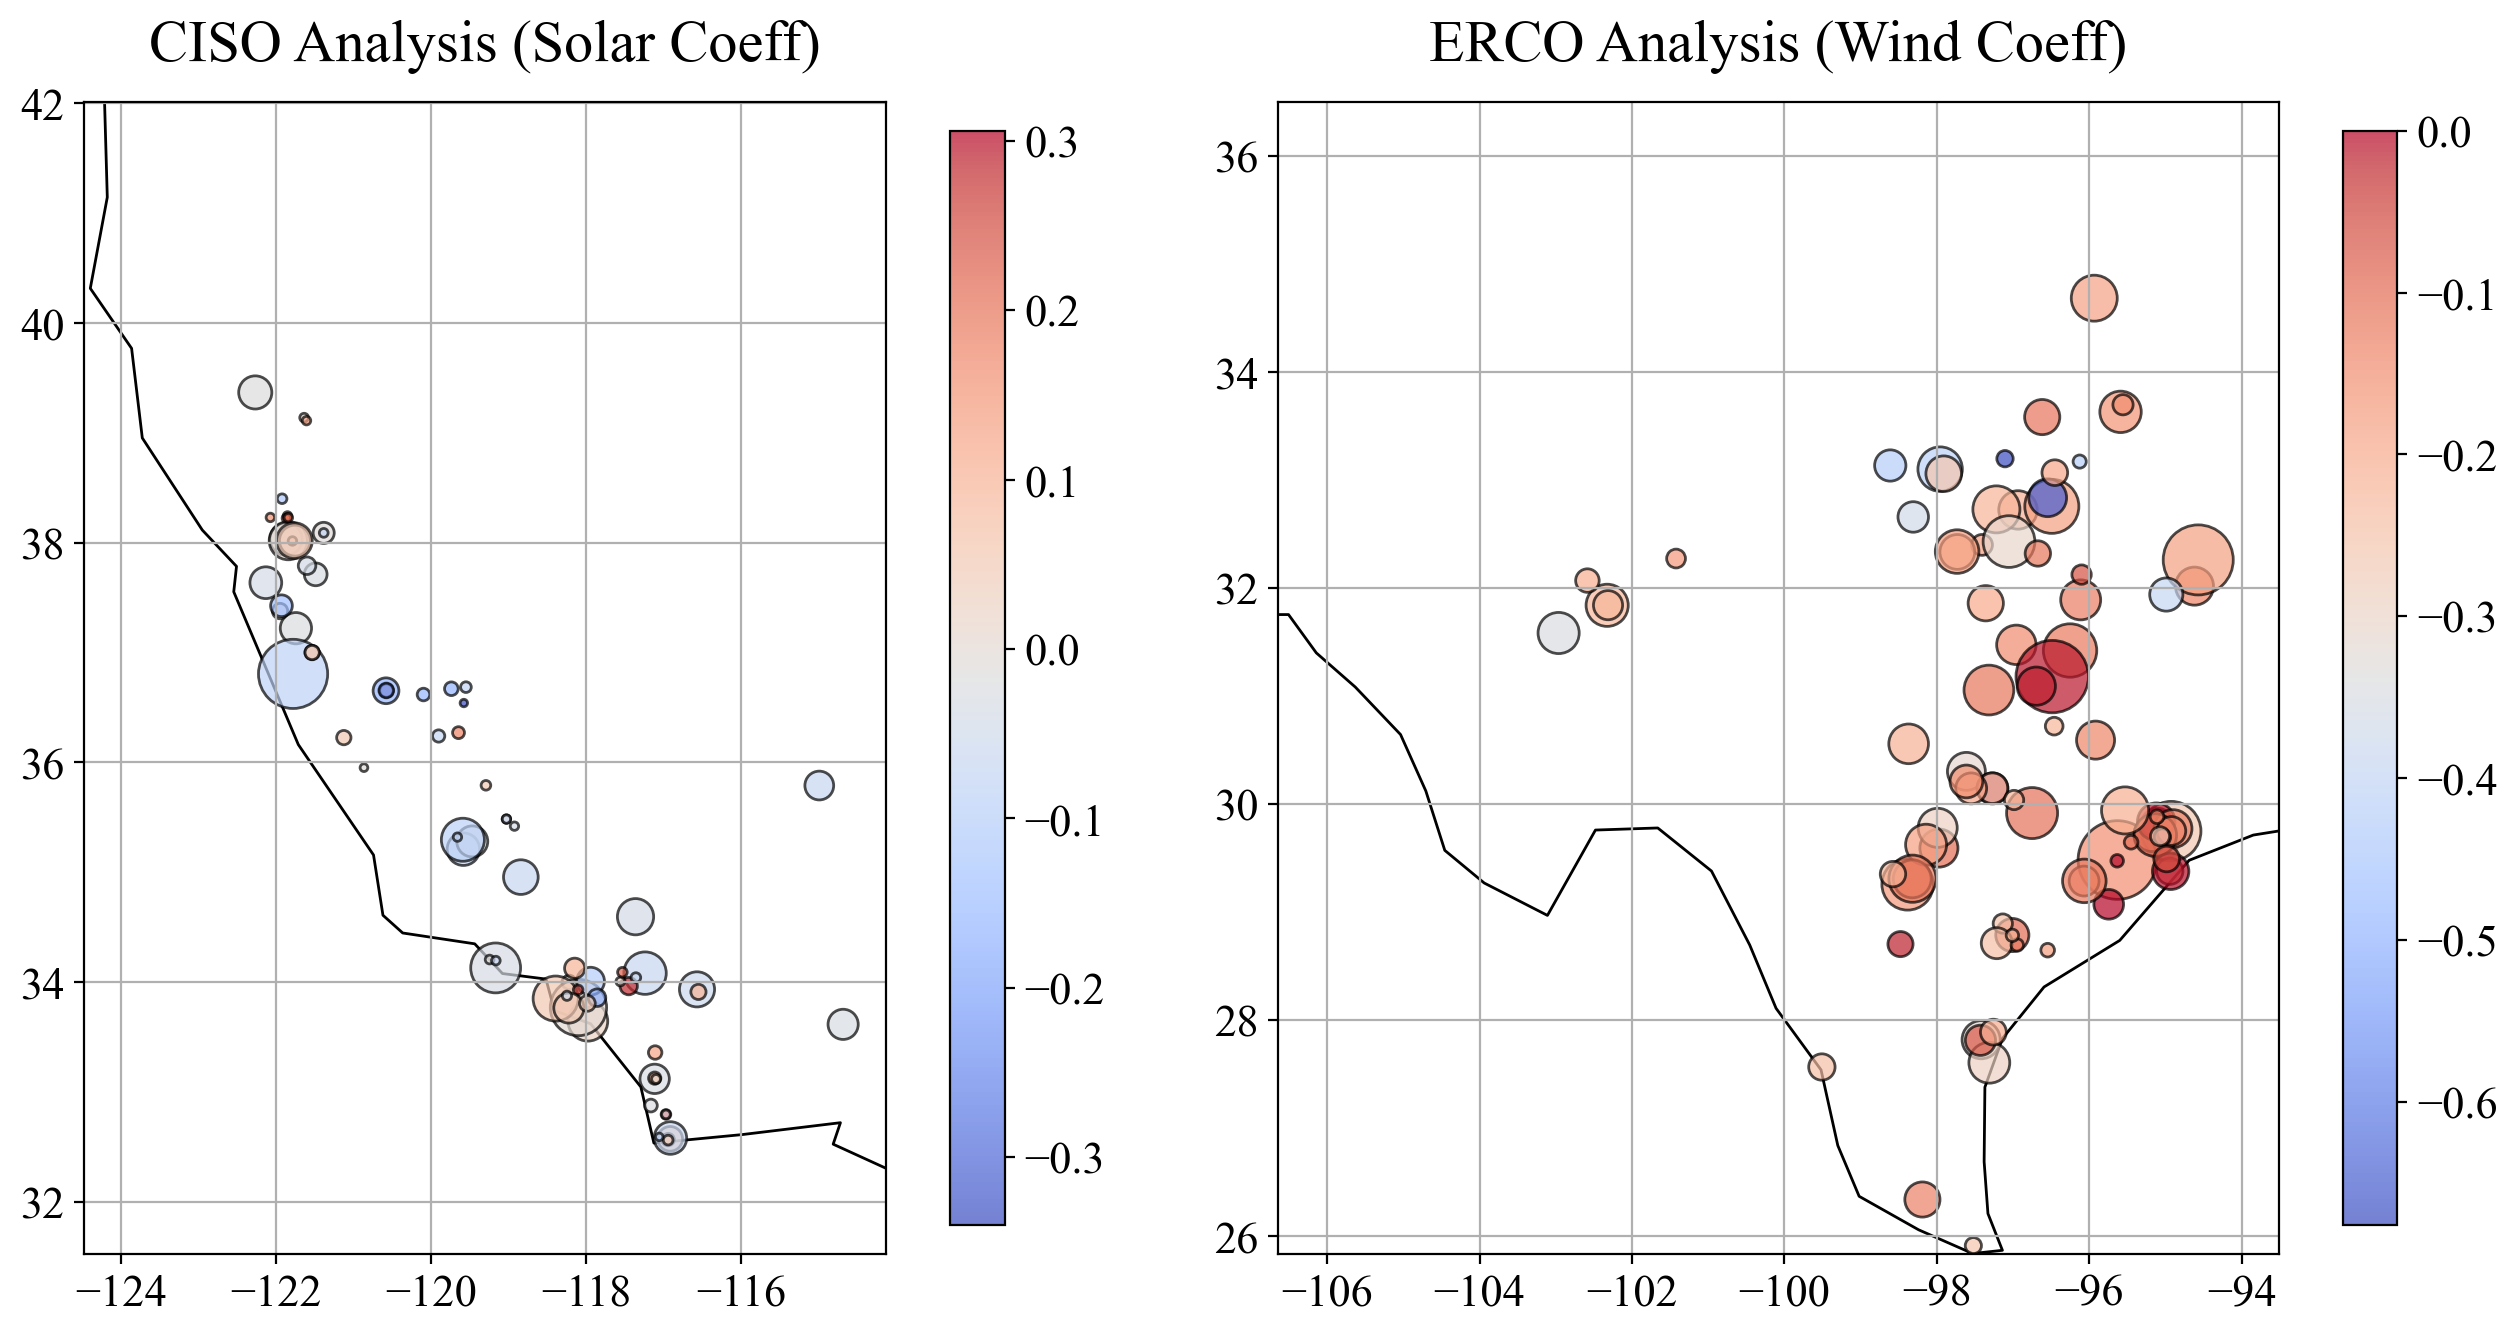

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming df_ciso_analysis and df_erco_analysis are your DataFrames and have been defined earlier

# Load a map of the world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for the United States, focusing on California and Texas by coordinates
usa = world[(world.name == "United States of America") & (world.iso_a3 == "USA")].copy()

# Convert your DataFrames to GeoDataFrames
gdf_ciso = gpd.GeoDataFrame(df_ciso_analysis, geometry=gpd.points_from_xy(df_ciso_analysis.LON, df_ciso_analysis.LAT))
gdf_erco = gpd.GeoDataFrame(df_erco_analysis, geometry=gpd.points_from_xy(df_erco_analysis.LON, df_erco_analysis.LAT))

# Create a figure with two subplots (horizontal)
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=False, sharey=False)

# Plot CISO Analysis with solar_coeff, focusing on California
usa.plot(ax=axes[0], color='white', edgecolor='black')
ciso_scatter = axes[0].scatter(gdf_ciso.geometry.x, gdf_ciso.geometry.y, s=gdf_ciso['NAMEPCAP']/5, c=gdf_ciso['solar_coeff'], cmap='coolwarm', edgecolor='black', alpha=0.7)
axes[0].set_title('CISO Analysis (Solar Coeff)')
axes[0].set_xlim([-124.48, -114.13])  # California
axes[0].set_ylim([31.53, 42.01])
axes[0].grid()

# Plot ERCO Analysis with wind_coeff, focusing on Texas
usa.plot(ax=axes[1], color='white', edgecolor='black')
erco_scatter = axes[1].scatter(gdf_erco.geometry.x, gdf_erco.geometry.y, s=gdf_erco['NAMEPCAP']/5, c=gdf_erco['wind_coeff'], cmap='coolwarm', edgecolor='black', alpha=0.7)
axes[1].set_title('ERCO Analysis (Wind Coeff)')
axes[1].set_xlim([-106.65, -93.51])  # Texas
axes[1].set_ylim([25.84, 36.5])
axes[1].grid()

# Create colorbars for each subplot
fig.colorbar(ciso_scatter, ax=axes[0], shrink=0.95, aspect=20)
fig.colorbar(erco_scatter, ax=axes[1], shrink=0.95, aspect=20)

plt.tight_layout()
plt.show()


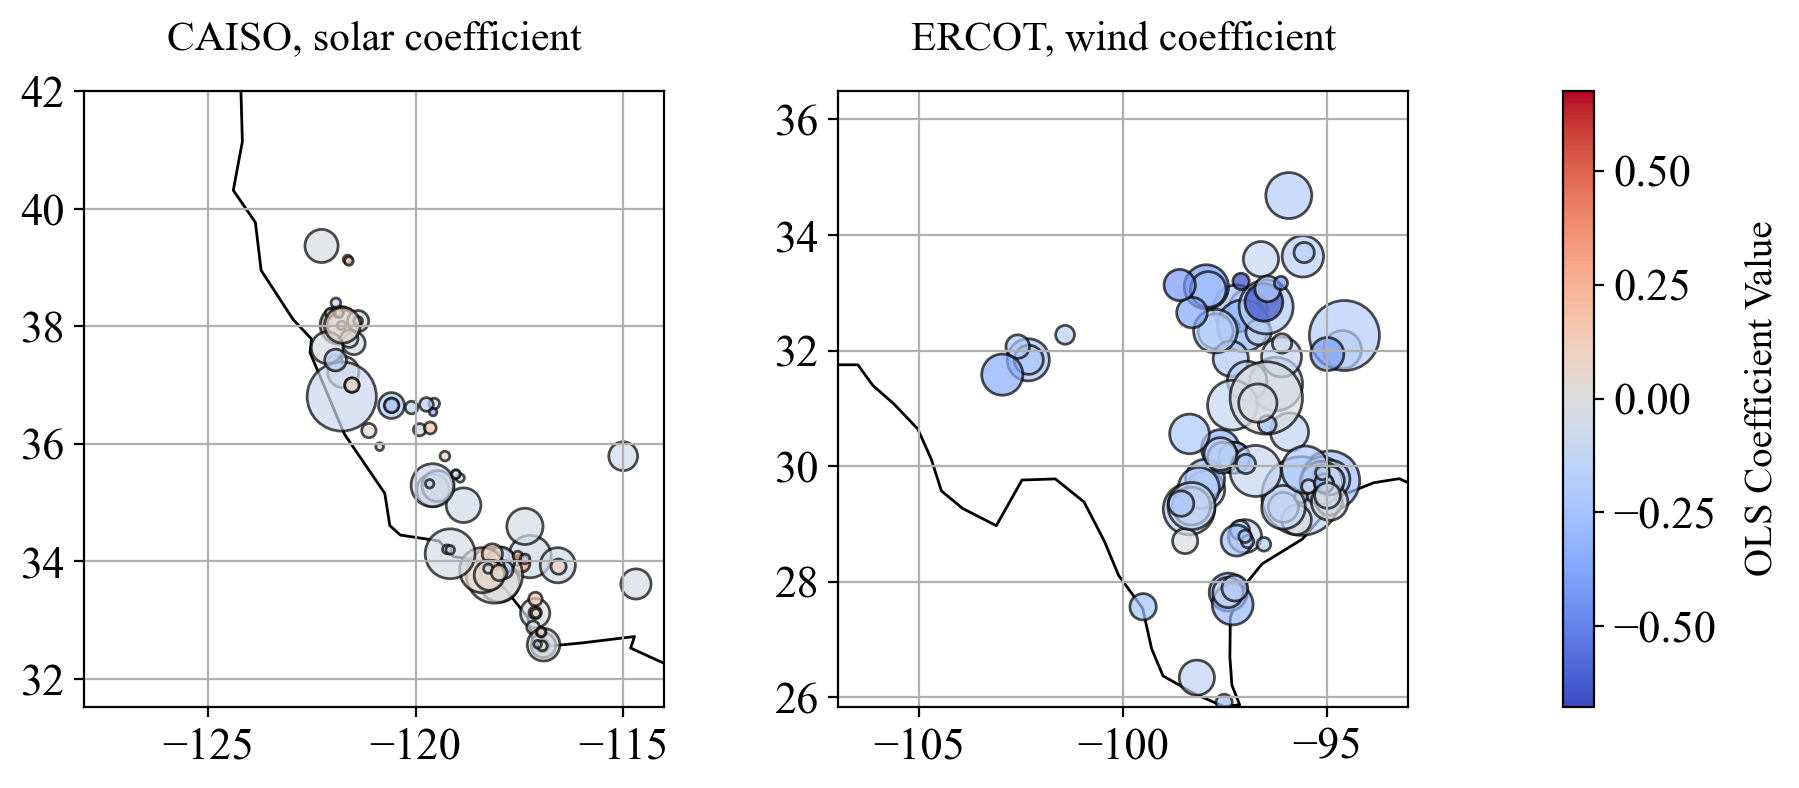

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming df_ciso_analysis and df_erco_analysis are your DataFrames and have been defined earlier

# Determine symmetric color scale limits based on the absolute max across both datasets
abs_max = max(abs(df_ciso_analysis['solar_coeff'].min()), df_ciso_analysis['solar_coeff'].max(), 
              abs(df_erco_analysis['wind_coeff'].min()), df_erco_analysis['wind_coeff'].max())
vmin, vmax = -abs_max, abs_max

# Normalize the color scale
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Load a map of the world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for the United States
usa = world[(world.name == "United States of America") & (world.iso_a3 == "USA")].copy()

# Convert your DataFrames to GeoDataFrames
gdf_ciso = gpd.GeoDataFrame(df_ciso_analysis, geometry=gpd.points_from_xy(df_ciso_analysis.LON, df_ciso_analysis.LAT))
gdf_erco = gpd.GeoDataFrame(df_erco_analysis, geometry=gpd.points_from_xy(df_erco_analysis.LON, df_erco_analysis.LAT))

# Create a figure with two subplots (horizontal)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False)

# Define the colormap
cmap = 'coolwarm'

# Plot CISO Analysis with solar_coeff, focusing on California
usa.plot(ax=axes[0], color='white', edgecolor='black')
ciso_scatter = axes[0].scatter(gdf_ciso.geometry.x, gdf_ciso.geometry.y, s=gdf_ciso['NAMEPCAP']/5, c=gdf_ciso['solar_coeff'], cmap=cmap, edgecolor='black', alpha=0.7, norm=norm)
axes[0].set_title('CAISO, solar coefficient',fontsize=15)
axes[0].set_xlim([-128, -114])  # California
axes[0].set_ylim([31.53, 42.01])
axes[0].grid()

# Plot ERCO Analysis with wind_coeff, focusing on Texas
usa.plot(ax=axes[1], color='white', edgecolor='black')
erco_scatter = axes[1].scatter(gdf_erco.geometry.x, gdf_erco.geometry.y, s=gdf_erco['NAMEPCAP']/5, c=gdf_erco['wind_coeff'], cmap=cmap, edgecolor='black', alpha=0.7, norm=norm)
axes[1].set_title('ERCOT, wind coefficient',fontsize=15)
axes[1].set_xlim([-107, -93])  # Texas
axes[1].set_ylim([25.84, 36.5])
axes[1].grid()

# Create a shared colorbar for both subplots, placed outside the plots
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label('OLS Coefficient Value',fontsize=14)

plt.show()


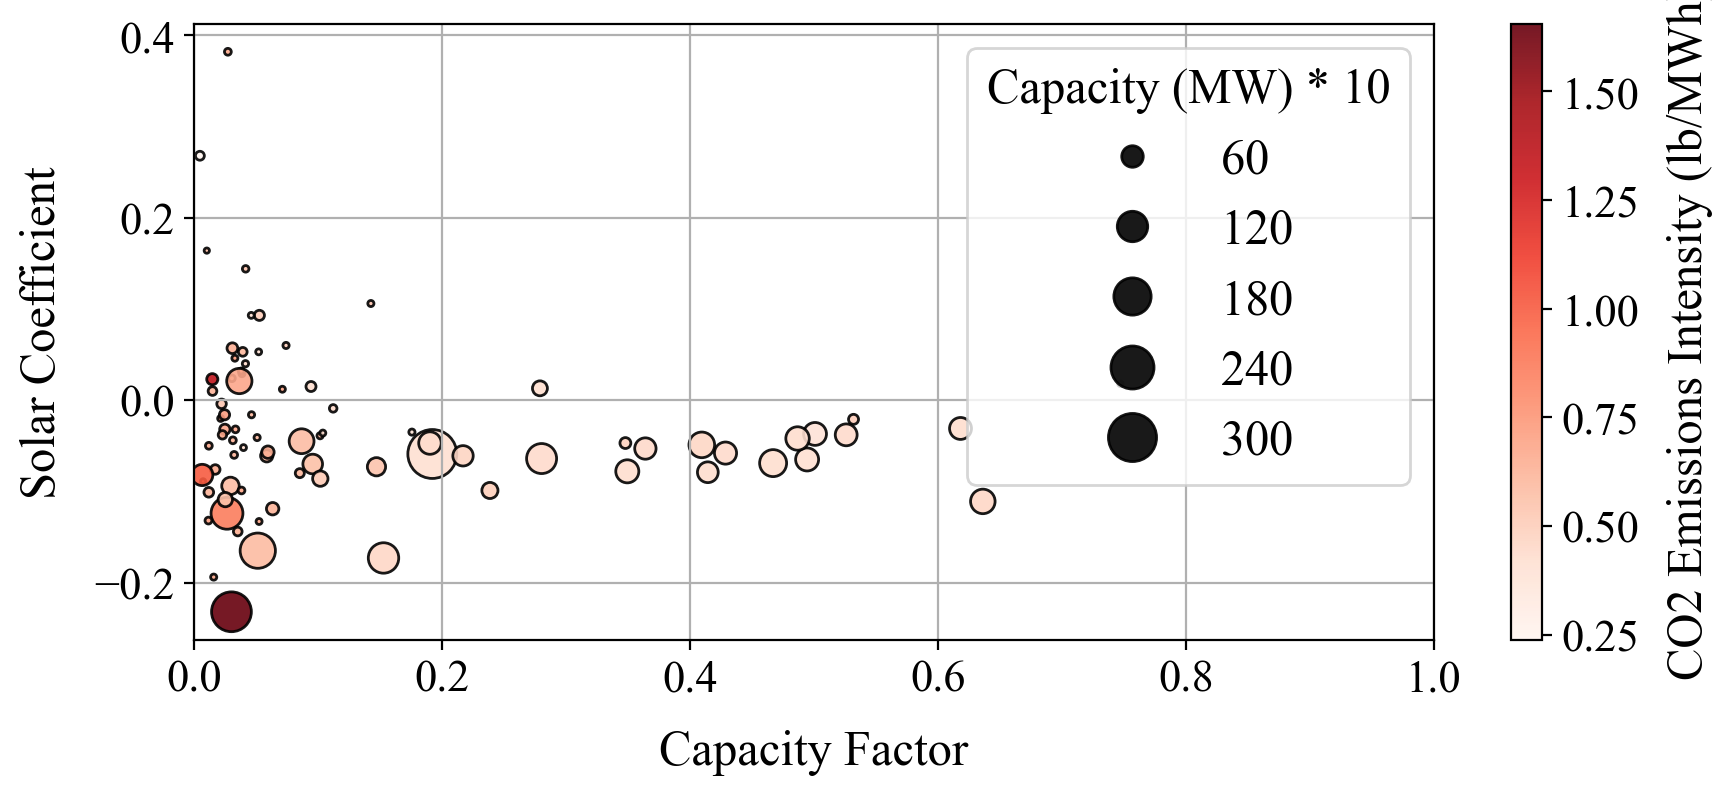

In [22]:
# in the above, create a copy of the df and only show plants that have an emissions intensity of less than 2000 lb/MWh
df_plants_low = df_ciso_analysis[df_ciso_analysis.CO2EI < 3]

fig, ax = plt.subplots(figsize=(10, 4))
scatter = ax.scatter(
    df_plants_low.CAPFAC,
    df_plants_low.wind_coeff,
    s=df_plants_low.NAMEPCAP / 10,
    c=df_plants_low.CO2EI,
    cmap="Reds",
    alpha=0.9,
    edgecolors="black",
)
cbar = plt.colorbar(scatter, ax=ax)  # Create a colorbar based on the mappable object
ax.set_xlabel("Capacity Factor")
ax.set_ylabel("Solar Coefficient")
cbar.set_label("CO2 Emissions Intensity (lb/MWh)")
ax.legend(
    *scatter.legend_elements("sizes", num=5, color="black"),
    title="Capacity (MW) * 10",
    loc="upper right"
)

# set x limit from 0 to 1
ax.set_xlim(0, 1)

ax.grid()

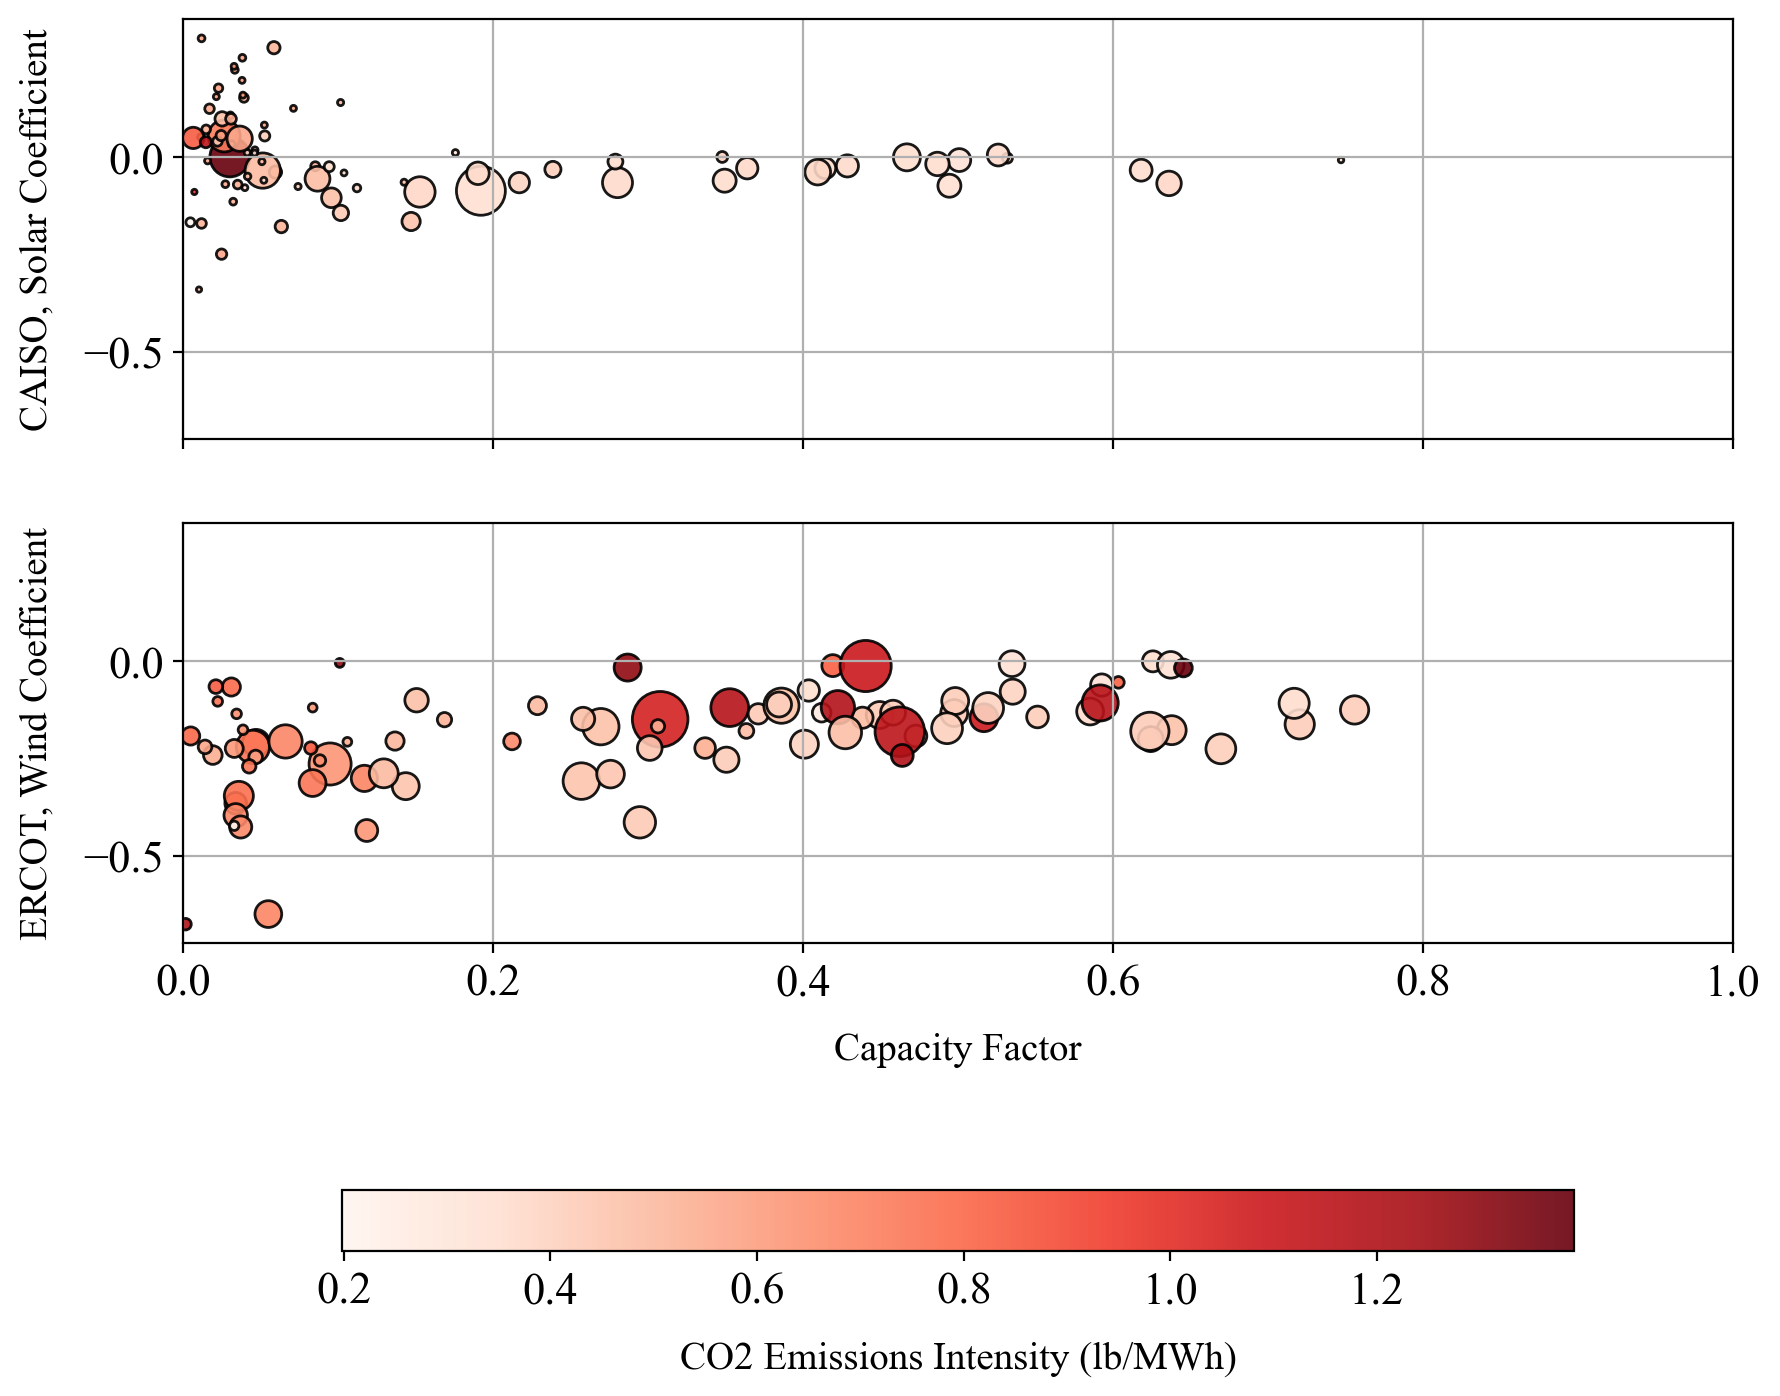

In [52]:
import re
import matplotlib.pyplot as plt

# Create two vertical subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex='all', sharey='all')

# Assuming df_ciso_low and df_erco_low are prepared

# CISO Solar Coefficient Plot
solar_scatter = axes[0].scatter(
    df_ciso_low.CAPFAC,
    df_ciso_low.solar_coeff,
    s=df_ciso_low.NAMEPCAP / 10,
    c=df_ciso_low.CO2EI,
    cmap="Reds",
    alpha=0.9,
    edgecolor="black",
)
axes[0].set_ylabel("CAISO, Solar Coefficient",fontsize=14)
axes[0].grid()

# ERCOT Wind Coefficient Plot
wind_scatter = axes[1].scatter(
    df_erco_low.CAPFAC,
    df_erco_low.wind_coeff,
    s=df_erco_low.NAMEPCAP / 10,
    c=df_erco_low.CO2EI,
    cmap="Reds",
    alpha=0.9,
    edgecolor="black",
)
axes[1].set_xlabel("Capacity Factor",fontsize=14)
axes[1].set_ylabel("ERCOT, Wind Coefficient",fontsize=14)
axes[1].grid()

# Set x limit from 0 to 1 for both plots (shared x-axis)
axes[1].set_xlim(0, 1)

# Shared colorbar at the bottom
cbar = fig.colorbar(wind_scatter, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.05, pad=0.2)
cbar.set_label("CO2 Emissions Intensity (lb/MWh)",fontsize=14)


plt.show()

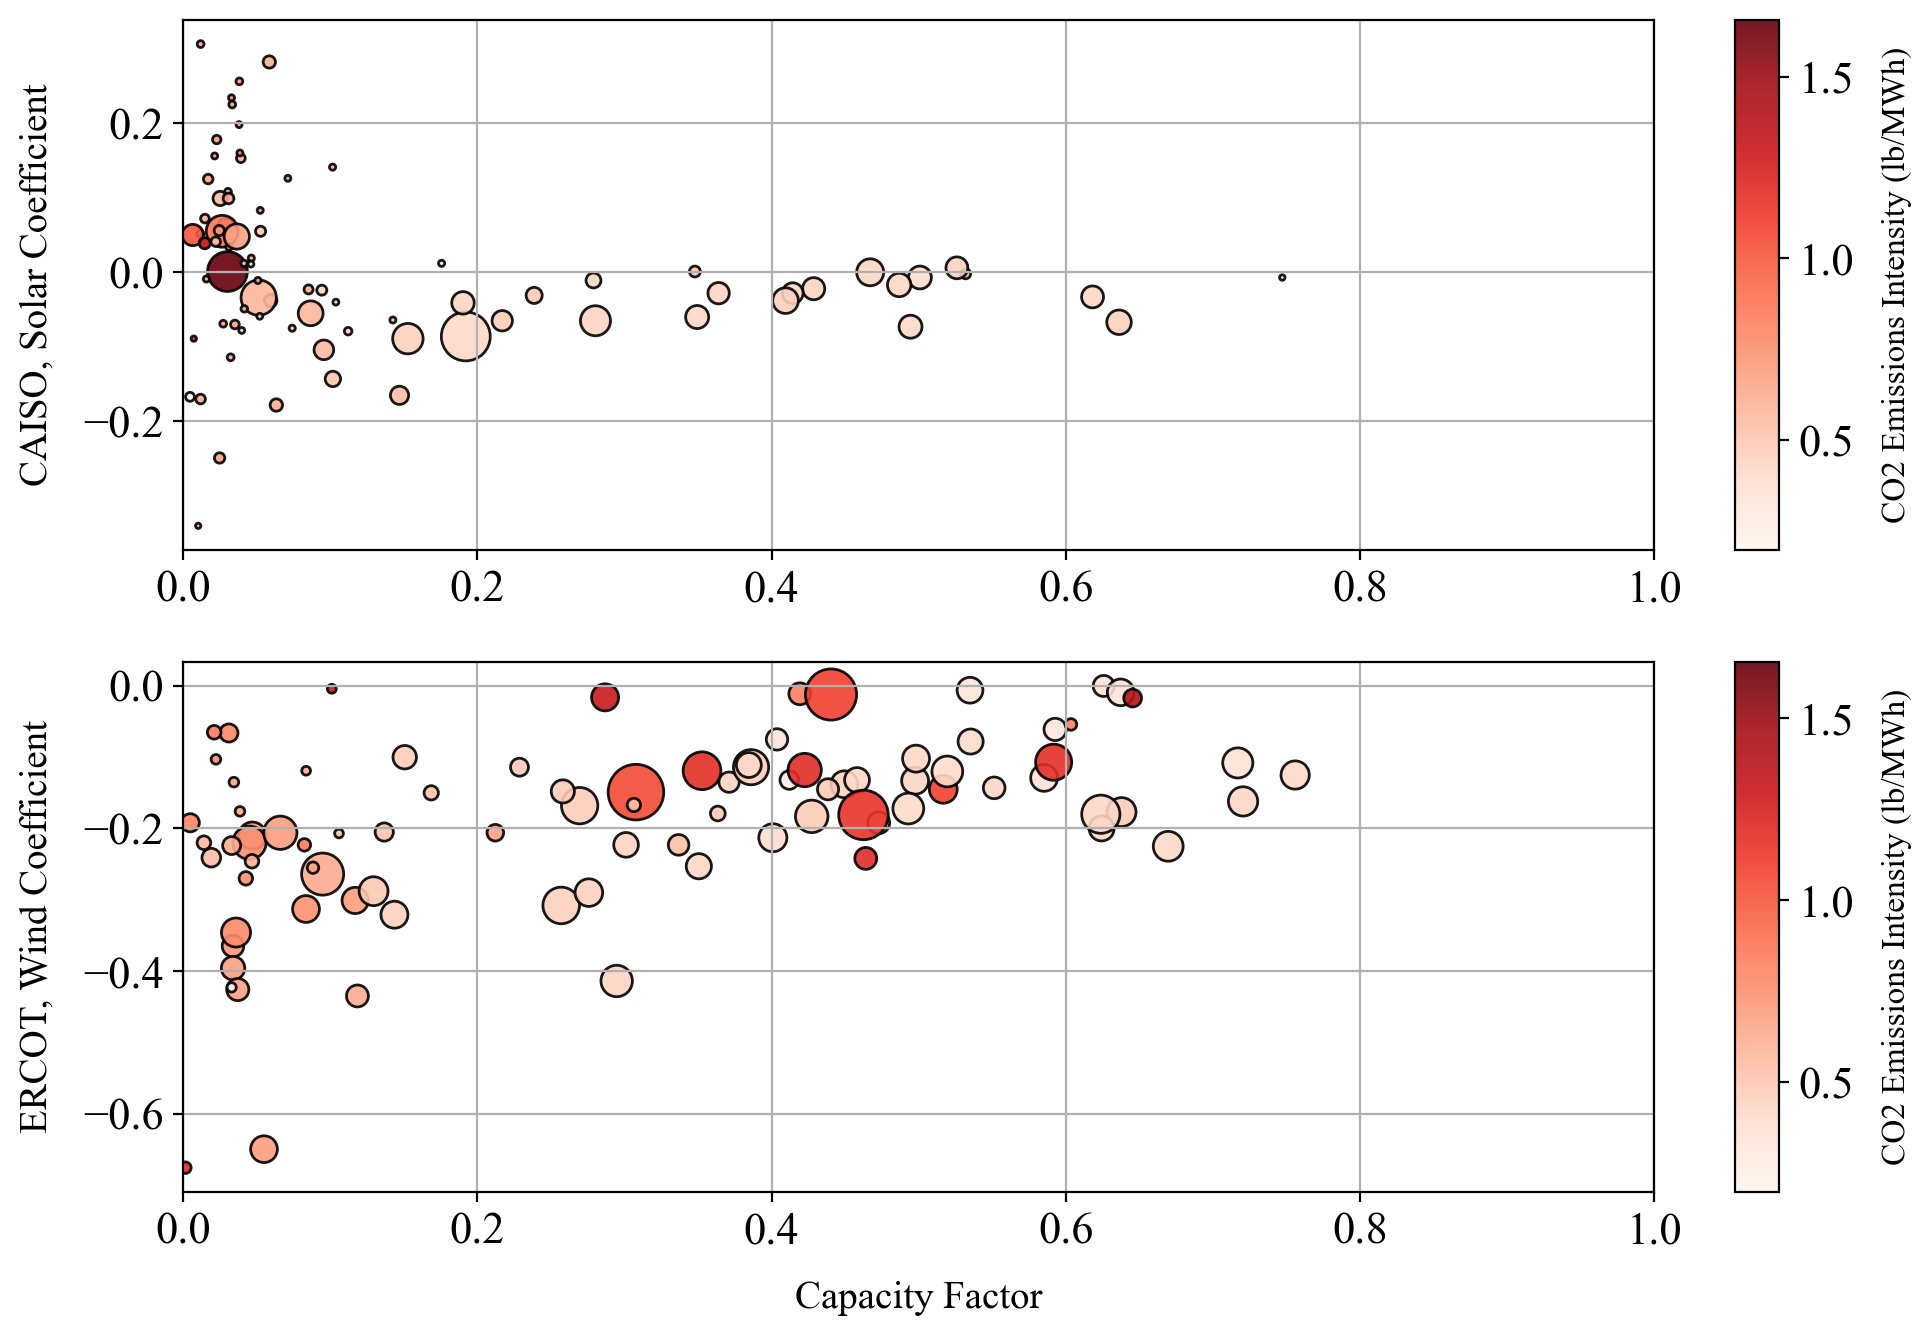

In [63]:
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Determine the global minimum and maximum CO2 Emissions Intensity for both datasets
global_min_CO2EI = min(df_ciso_low.CO2EI.min(), df_erco_low.CO2EI.min())
global_max_CO2EI = max(df_ciso_low.CO2EI.max(), df_erco_low.CO2EI.max())

# Create figure and subplots using gridspec for custom layout
fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[5, 0.15], height_ratios=[1,1])

# CISO Solar Coefficient Plot
ax0 = fig.add_subplot(gs[0, 0])  # First row, first column
solar_scatter = ax0.scatter(
    df_ciso_low.CAPFAC,
    df_ciso_low.solar_coeff,
    s=df_ciso_low.NAMEPCAP / 10,
    c=df_ciso_low.CO2EI,
    cmap="Reds",
    alpha=0.9,
    edgecolor="black",
    vmin=global_min_CO2EI,  # Use global min and max for color normalization
    vmax=global_max_CO2EI
)
ax0.set_ylabel("CAISO, Solar Coefficient", fontsize=14)
ax0.set_xlim(0, 1)  # Ensure shared x-axis range
ax0.grid()

# ERCOT Wind Coefficient Plot
ax1 = fig.add_subplot(gs[1, 0])  # Second row, first column
wind_scatter = ax1.scatter(
    df_erco_low.CAPFAC,
    df_erco_low.wind_coeff,
    s=df_erco_low.NAMEPCAP / 10,
    c=df_erco_low.CO2EI,
    cmap="Reds",
    alpha=0.9,
    edgecolor="black",
    vmin=global_min_CO2EI,  # Use global min and max for color normalization
    vmax=global_max_CO2EI
)
ax1.set_xlabel("Capacity Factor", fontsize=14)
ax1.set_ylabel("ERCOT, Wind Coefficient", fontsize=14)
ax1.set_xlim(0, 1)  # Explicitly set here for clarity
ax1.grid()

# Add colorbars adjacent to each plot, with normalized limits
cbar_ax0 = fig.add_subplot(gs[0, 1])  # For CAISO
cbar0 = fig.colorbar(solar_scatter, cax=cbar_ax0, orientation='vertical')
cbar0.set_label("CO2 Emissions Intensity (lb/MWh)", fontsize=12)

cbar_ax1 = fig.add_subplot(gs[1, 1])  # For ERCOT
cbar1 = fig.colorbar(wind_scatter, cax=cbar_ax1, orientation='vertical')
cbar1.set_label("CO2 Emissions Intensity (lb/MWh)", fontsize=12)

fig.tight_layout()
plt.show()